# Highway ramp exploration
  
### Purpose & Motivation
As we have discovered with previous analysis, a set of oscillations in traffic flow (wiggles) appears within the mean flow of the main-line highway sensors (ie. main lanes of travel).  These fluctuations exhibit a period of approximately $\frac{1}{2}$ hour.

We have hypothesized these wiggles are an artifact of the natural rhythm of travelers attempting to arrive at their destination or leaving from their start point on the hour or half-hour.  However, it is also possible that these fluctuations are due to the method by which the data is collected and processed.  The following analysis attempts to discover evidence that the oscillations are not an artifact of data collection.

### Hypothesis
On-ramp and off-ramp mean flow data exhibit patterns (oscillations) which can be correlated to oscillations in the mean flow of the main-line (eg. phase shifted).  In particular we hypothesis the following are true:
- Areas of high commercial concentration will experience peaks in the off-ramp oscillations just _prior to_ the hour and half-hour during the _morning_ hours.
- These same commercial-heavy areas will experience peaks in on-ramp oscillations just _after_ the hour and half-hour during the _evening_ hours.
- Areas of high residential concentration will experience valleys in the on-ramp oscillations near the hour and half-hour during the _morning_ hours.
 

### Tasks/Questions to Answer
#### Questions to Answer
- What patterns (if any) exist in the off-ramp mean flow oscillations in the morning and evening?
- What patterns (if any) exist in the on-ramp mean flow oscillations in the morning and evening?
- How are these patterns related to the mean main-line flow oscillations?

#### Tasks
- Select data subset (in this case, I-5 South for the year 2015)
- Calculate mean flow for each station (station-day vector)
- Calculate smoothed mean flow for each station
- Subtract smoothed mean from raw mean to isolate oscillations (wiggles) for each station
- Identify station clusters (on-ramp and/or off-ramp plus main-line stations preceding and anteceding)
- Plot station clusters

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
import numpy as np
import time
from os import listdir
from os.path import isfile, join
from datetime import time

import datetime as dt

import glob


import sys
sys.path.append('../')
import trafficpassion.AnalyzeWiggles as aw

from IPython.display import Image

In [2]:
#data locations
data_5min_path = "../../../data/5min/2015/d11/"
meta_path = "../../../data/meta/2015/d11/"

### Data files

In [3]:
#get all files to process
onlyfiles = [f for f in listdir(data_5min_path) if isfile(join(data_5min_path, f))]

In [4]:
onlyfiles[0:3]

['d11_text_station_5min_2015_01_01.txt.gz',
 'd11_text_station_5min_2015_01_02.txt.gz',
 'd11_text_station_5min_2015_01_03.txt.gz']

In [5]:
colnames = [
    'Timestamp','Station','District','Freeway','Direction_of_Travel',
    'LaneType','StationLength','Samples',
    'Perc_Observed','TotalFlow','AvgOccupancy','AvgSpeed',
    'Lane1_Samples','Lane1_Flow','Lane1_AvgOcc','Lane1_AvgSpeed','Lane1_Observed',
    'Lane2_Samples','Lane2_Flow','Lane2_AvgOcc','Lane2_AvgSpeed','Lane2_Observed',
    'Lane3_Samples','Lane3_Flow','Lane3_AvgOcc','Lane3_AvgSpeed','Lane3_Observed',
    'Lane4_Samples','Lane4_Flow','Lane4_AvgOcc','Lane4_AvgSpeed','Lane4_Observed',
    'Lane5_Samples','Lane5_Flow','Lane5_AvgOcc','Lane5_AvgSpeed','Lane5_Observed',
    'Lane6_Samples','Lane6_Flow','Lane6_AvgOcc','Lane6_AvgSpeed','Lane6_Observed',
    'Lane7_Samples','Lane7_Flow','Lane7_AvgOcc','Lane7_AvgSpeed','Lane7_Observed',
    'Lane8_Samples','Lane8_Flow','Lane8_AvgOcc','Lane8_AvgSpeed','Lane8_Observed'
]
colnames = [c.lower() for c in colnames]

In [6]:
len(colnames)

52

In [7]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

### Build Spark schema and dataframe

struct list was generated with the following code after reading the files with inferschema = true, then hand modified 
```
'[' + ','.join(['StructField("%s",%s(),True)'% (colnames[idx], str(i.dataType))
for idx, i in enumerate(rdd.schema)]) + ']'
```

In [8]:
struct_list = [
    StructField("timestamp",TimestampType(),True),
    StructField("station",IntegerType(),True),
    StructField("district",IntegerType(),True),
    StructField("freeway",IntegerType(),True),
    StructField("direction_of_travel",StringType(),True),
    StructField("lanetype",StringType(),True),
    StructField("stationlength",DoubleType(),True),
    StructField("samples",IntegerType(),True),
    StructField("perc_observed",IntegerType(),True),
    StructField("totalflow",IntegerType(),True),
    StructField("avgoccupancy",DoubleType(),True),
    StructField("avgspeed",DoubleType(),True),
    StructField("lane1_samples",IntegerType(),True),
    StructField("lane1_flow",IntegerType(),True),
    StructField("lane1_avgocc",DoubleType(),True),
    StructField("lane1_avgspeed",DoubleType(),True),
    StructField("lane1_observed",IntegerType(),True),
    StructField("lane2_samples",IntegerType(),True),
    StructField("lane2_flow",IntegerType(),True),
    StructField("lane2_avgocc",DoubleType(),True),
    StructField("lane2_avgspeed",DoubleType(),True),
    StructField("lane2_observed",IntegerType(),True),
    StructField("lane3_samples",IntegerType(),True),
    StructField("lane3_flow",IntegerType(),True),
    StructField("lane3_avgocc",DoubleType(),True),
    StructField("lane3_avgspeed",DoubleType(),True),
    StructField("lane3_observed",IntegerType(),True),
    StructField("lane4_samples",IntegerType(),True),
    StructField("lane4_flow",IntegerType(),True),
    StructField("lane4_avgocc",DoubleType(),True),
    StructField("lane4_avgspeed",DoubleType(),True),
    StructField("lane4_observed",IntegerType(),True),
    StructField("lane5_samples",IntegerType(),True),
    StructField("lane5_flow",IntegerType(),True),
    StructField("lane5_avgocc",DoubleType(),True),
    StructField("lane5_avgspeed",DoubleType(),True),
    StructField("lane5_observed",IntegerType(),True),
    StructField("lane6_samples",IntegerType(),True),
    StructField("lane6_flow",IntegerType(),True),
    StructField("lane6_avgocc",DoubleType(),True),
    StructField("lane6_avgspeed",DoubleType(),True),
    StructField("lane6_observed",IntegerType(),True),
    StructField("lane7_samples",IntegerType(),True),
    StructField("lane7_flow",IntegerType(),True),
    StructField("lane7_avgocc",DoubleType(),True),
    StructField("lane7_avgspeed",DoubleType(),True),
    StructField("lane7_observed",IntegerType(),True),
    StructField("lane8_samples",IntegerType(),True),
    StructField("lane8_flow",IntegerType(),True),
    StructField("lane8_avgocc",DoubleType(),True),
    StructField("lane8_avgspeed",DoubleType(),True),
    StructField("lane8_observed",IntegerType(),True)
]

schema_struct = StructType(struct_list)

In [9]:
#node this is only the first 5 days of files for now
files = [data_5min_path + filename for filename in onlyfiles]#[:5]]

rdd = spark.read.csv(
    files, 
    header='false',
    timestampFormat='MM/dd/yyyy HH:mm:ss',
    schema=schema_struct,
    inferSchema='false'
)
    
rdd.take(1)

[Row(timestamp=datetime.datetime(2015, 2, 20, 0, 0), station=1100313, district=11, freeway=5, direction_of_travel=u'N', lanetype=u'FR', stationlength=None, samples=10, perc_observed=100, totalflow=12, avgoccupancy=None, avgspeed=None, lane1_samples=10, lane1_flow=12, lane1_avgocc=None, lane1_avgspeed=None, lane1_observed=1, lane2_samples=None, lane2_flow=None, lane2_avgocc=None, lane2_avgspeed=None, lane2_observed=0, lane3_samples=None, lane3_flow=None, lane3_avgocc=None, lane3_avgspeed=None, lane3_observed=0, lane4_samples=None, lane4_flow=None, lane4_avgocc=None, lane4_avgspeed=None, lane4_observed=0, lane5_samples=None, lane5_flow=None, lane5_avgocc=None, lane5_avgspeed=None, lane5_observed=0, lane6_samples=None, lane6_flow=None, lane6_avgocc=None, lane6_avgspeed=None, lane6_observed=0, lane7_samples=None, lane7_flow=None, lane7_avgocc=None, lane7_avgspeed=None, lane7_observed=0, lane8_samples=None, lane8_flow=None, lane8_avgocc=None, lane8_avgspeed=None, lane8_observed=0)]

In [10]:
rdd.count()

154289957

In [10]:
from pyspark.sql.functions import hour, mean,minute, stddev, count,max as psmax,min as psmin

In [11]:
station_time = (
    rdd.groupBy([
        'station',
        hour("timestamp").alias("hour"),
        minute("timestamp").alias("minute")
    ]).agg(
        mean("totalflow").alias("flow_mean"),
        stddev("totalflow").alias("flow_std"),
        count("totalflow").alias("flow_count"),
        psmax("totalflow").alias("flow_max"),
        psmin("totalflow").alias("flow_min")
    )
)
#station_time.show(10)

In [46]:
%%timeit
df = station_time.toPandas()

1 loop, best of 3: 7.47 s per loop


In [47]:
df.station.unique().shape

(1541,)

In [14]:
df['flow_std_plus_mean'] = df.flow_mean + df.flow_std
df['flow_std_minus_mean'] = df.flow_mean - df.flow_std

In [15]:
df['time'] = df.apply(lambda x:time(int(x.hour),int(x.minute)),axis = 1)

In [16]:
df.sort_values('time',inplace=True)

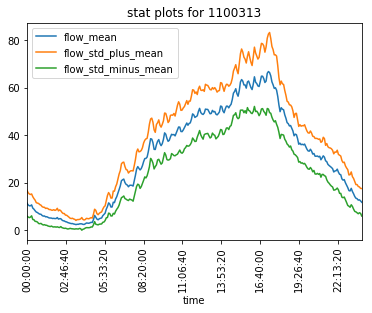

In [18]:
for g,g_df in  df.groupby('station'):
    g_df.plot(
        x='time', 
        y=['flow_mean','flow_std_plus_mean','flow_std_minus_mean'],
        title='stat plots for %i'%g,
        rot=90
    )
    plt.show()
    break

In [19]:

from scipy.interpolate import interp1d, Akima1DInterpolator
from sklearn import preprocessing
def interpolate(meanVector, kind, factor):
    y = meanVector
    y_len = len(y)
    x = np.arange(0,y_len)
    
    interpolator = {
        'akima': Akima1DInterpolator(x, y),
        'cubic': interp1d(x, y, kind='cubic'),
        'linear': interp1d(x, y, kind='linear')
    }
    
    interpolate = interpolator[kind]

    mid_factor = factor/2
    
    interp = [interpolate(np.arange(i,y_len, factor)) for i in range(factor)]
    myArray = reduce(lambda x,y:x+y,interp)

    my_x = np.arange(mid_factor,y_len, factor)
    
    extrapolator = {
        'akima': Akima1DInterpolator(my_x, myArray/factor),
        'cubic': interp1d(my_x, myArray/factor, kind='cubic'),
        'linear': interp1d(my_x, myArray/factor, kind='linear')
    }
    
    extrapolate = extrapolator[kind]
    
    new_x = np.arange(mid_factor,y_len-mid_factor)
    interpolated = extrapolate( np.arange(mid_factor,y_len-mid_factor))

    #wut??
    #pad front and back with mean vector 
    xprime = np.append(np.arange(0,mid_factor), new_x)
    xprime = np.append(xprime, np.arange(max(xprime)+1,y_len))
    yprime = np.append(y[:mid_factor], interpolated)
    yprime = np.append(yprime, y[-mid_factor:])

    return yprime


def smooth_vector(meanVector, kind='akima', factor=6):
    smoothedVector = interpolate(meanVector, kind, factor )
    diff = meanVector - smoothedVector
    diffVector = diff/np.linalg.norm(diff) 
    
    return {  
        'smoothedVector': smoothedVector, 
        'diffVector': diffVector
    }

vectors = smooth_vector(g_df['flow_mean'].values, 'akima', 12)

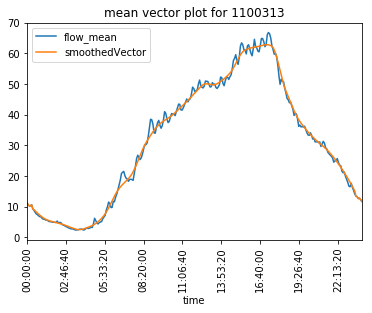

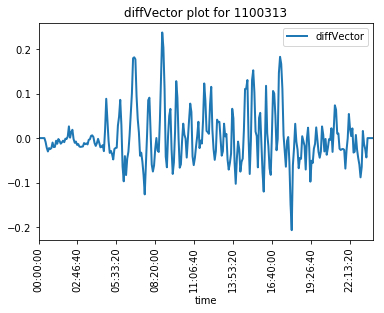

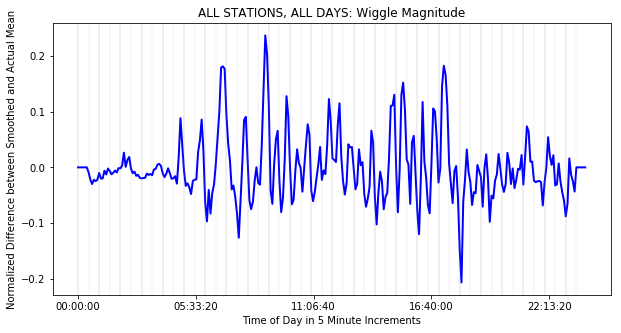

In [20]:
vectors = smooth_vector(g_df['flow_mean'].values, 'akima', 12)
g_df['smoothedVector'] = vectors['smoothedVector']
g_df['diffVector'] = vectors['diffVector']

g_df.plot(
    x='time',
    y=['flow_mean','smoothedVector'], 
    rot=90,
    title='mean vector plot for %i'%(g)
)

g_df.plot(
    x='time',
    y='diffVector',
    rot=90,
    linewidth=2,
    title='diffVector plot for %i'%(g)
)

plt.figure(figsize = (10,5))
plt.plot(g_df['time'],g_df['diffVector'], color="blue", linewidth=2)
plt.title("ALL STATIONS, ALL DAYS: Wiggle Magnitude")
for i in range(0,288,12):
    plt.axvline(x=g_df['time'].iloc[i], linewidth=.25, color='gray')
    plt.axvline(x=g_df['time'].iloc[i+6], linewidth=.1, color='gray')

plt.xlabel('Time of Day in 5 Minute Increments')
plt.ylabel('Normalized Difference between Smoothed and Actual Mean')
plt.show()

#### Load metadata and identify all FR OR and their preceding and anteceding station

In [21]:
def loadMeta():
    #meta_dir='../data/External/meta/2015/d11/d11_text_meta_2015_*.txt'
    meta_dir= meta_path + 'd11_text_meta_2015_*.txt'
    meta_files = glob.glob(meta_dir)

    meta_file_list = []
    for meta_file in meta_files:
        date = str('_'.join(meta_file.split('_')[4:7])).split('.')[0]
        df = pd.read_table(meta_file, index_col=None, header=0)
        date_col = pd.Series([date] * len(df))
        df['file_date'] = date_col
        # drop rows that are missing latitude / longitude values
        #df.dropna(inplace=True, subset=['Latitude', 'Longitude'], how='any')
        meta_file_list.append(df)

    meta_frame = pd.concat(meta_file_list).drop_duplicates(subset='ID', keep='last')

    usefwy = [ 56, 125, 805,  52, 163,   8,  15,   5, 905,  78,  94,  54]

    meta_frame = meta_frame[meta_frame.Fwy.apply(lambda x: x in usefwy)]

    #Add freeway name FwyDir
    meta_frame['freeway'] = meta_frame.Fwy.apply(str) + meta_frame.Dir
    
    r_c = {}
    for c in meta_frame.columns:
        r_c[c]=c.lower()
    
    meta_frame=meta_frame.rename(columns = r_c )
    return meta_frame

loadMeta().head(1)

id  fwy dir  district  county     city state_pm  abs_pm   latitude  \
584  1113072   56   W        11      73  66000.0    7.383   7.885  32.955202   

      longitude  length type  lanes               name  user_id_1  user_id_2  \
584 -117.124689   0.452   ML      2  Black Mountain Rd        314        NaN   

     user_id_3  user_id_4 file_date freeway  
584        NaN        NaN     01_01     56W

In [86]:
meta_df[ (meta_df.fwy==5) & (meta_df.dir=='S')] \
    .sort_values('abs_pm', ascending=False) \
    .set_index( ['abs_pm', 'type'] ) \
    [['id', 'latitude', 'longitude', 'lanes', 'name']]

id   latitude   longitude  lanes                  name
abs_pm type                                                             
72.008 ML    1121740  33.394031 -117.592254      5  5 SB Cristianitos Rd
70.878 ML    1121734  33.383349 -117.578043      4      5 SB Basilone Rd
68.279 ML    1121728  33.362845 -117.540736      4    5 SB Nuclear Plant
65.449 ML    1121722  33.336536 -117.503249      4     5 SB Truck Scales
65.448 ML    1121715  33.336526 -117.503236      4      5 NB Track Scale
62.419 ML    1121712  33.303834 -117.470867      4   5 SB  Las Pulgas Rd
60.429 ML    1121702  33.281440 -117.449446      4    5 SB N/O Rest Area
58.329 ML    1119997  33.257953 -117.426547      4    1M S/O ALISO CREEK
56.858 ML    1119978  33.240152 -117.413376      4   .5 N/O STA MARGRITA
55.858 ML    1119966  33.230196 -117.400904      4   S/O SANTA MARGARITA
54.858 ML    1119954  33.218567 -117.391109      4   S5 N/O CAMP DEL MAR
54.292 OR    1122250  33.210909 -117.387715      3      SB 5 @ HARBOR DR
       FR    1122252  33.210909 -117.387715      2      SB 5 @ HARBOR DR
       ML    1122257  33.210909 -117.387715      4      SB 5 @ HARBOR DR
53.658 ML    1115348  33.203488 -117.381365      4              SB 5 @76
53.159 OR    1108674  33.200623 -117.373450      1     EB RTE 76/MISSION
53.158 ML    1108672  33.200618 -117.373434      4     WB RTE 76/MISSION
       OR    1108673  33.200618 -117.373434      2     WB RTE 76/MISSION
       FR    1113776  33.200618 -117.373434      2     WB RTE 76/MISSION
52.266 FR    1113780  33.191277 -117.363281      2        OCEANSIDE BLVD
       ML    1108459  33.191277 -117.363281      4        Oceanside Blvd
       OR    1108460  33.191277 -117.363281      2        OCEANSIDE BLVD
51.293 ML    1108461  33.179734 -117.353651      4            CASSIDY ST
       OR    1108462  33.179734 -117.353651      1            CASSIDY ST
51.271 FR    1113782  33.179471 -117.353435      1            CASSIDY ST
50.568 OR    1108464  33.170920 -117.346811      1         LAS FLORES DR
       FR    1113788  33.170920 -117.346811      2         LAS FLORES DR
       ML    1108463  33.170920 -117.346811      4         LAS FLORES DR
49.948 FR    1113791  33.162818 -117.342266      2   CARLSBAD VILLAGE DR
       OR    1108658  33.162818 -117.342266      1   CARLSBAD VILLAGE DR
...              ...        ...         ...    ...                   ...
16.001 ML    1108417  32.723898 -117.156068      5               5th Ave
15.698 ML    1117683  32.723795 -117.151061      6        SB5 @PARK BLVD
15.628 ML    1114318  32.723198 -117.150182      6    South of Park Blvd
15.230 ML    1117810  32.718001 -117.147844      4           SB 5 @ B ST
14.856 ML    1117789  32.712581 -117.147751      4          SB 5 @ SR 94
14.677 ML    1122726  32.709980 -117.147760      5  North of Imperial Av
14.416 ML    1117774  32.706200 -117.147722      5        SB5 @ Imperial
13.372 ML    1114268  32.695740 -117.135196      5           N/O 28TH ST
13.022 ML    1117755  32.694358 -117.129467      4         SB 5 S/O 29th
12.748 ML    1114261  32.694108 -117.124841      4        5 SB N/O SR-15
12.113 ML    1118076  32.688779 -117.116159      4         SB I5 S/O I15
11.848 ML    1114254  32.686001 -117.113072      5          N/O DIVISION
11.178 ML    1118472  32.676960 -117.109463      4       5 SB N/O 8th St
10.796 ML    1118465  32.671761 -117.111234      4    5 SB  Civic Center
9.898  ML    1114240  32.658893 -117.107675      4         Bay Marina Dr
8.710  ML    1120603  32.642724 -117.101267      4          SB5 N/O E ST
8.491  ML    1122601  32.639722 -117.100176      5       E St on to 5 SB
8.489  ML    1118442  32.639695 -117.100165      4           5 SB @ E St
7.819  ML    1118428  32.630458 -117.096492      4         5 SB N/O H St
7.201  ML    1118413  32.621946 -117.093171      4           5 SB @ J St
6.627  ML    1120356  32.613849 -117.091173      3         SB 5 S/O L St
6.211  ML    1114749  32.607870 -117.090464      5        N/O PALOMAR ST
5.3

In [87]:
meta_df = loadMeta()
meta_df = meta_df[ meta_df.type.isin(['ML', 'OR', 'FR']) ]

In [88]:
i5s_mask = (meta_df.fwy==5) & (meta_df.dir=='S')
meta_group = meta_df[ i5s_mask ] \
    .sort_values('abs_pm', ascending=False) \
    .groupby('abs_pm')

#### Create sets of related stations

In [26]:
postmiles = meta_df[i5s_mask].sort_values('abs_pm', ascending=False).abs_pm.unique()

station_set = []
stations = []

prev_ml, next_ml = 0, 0
for i, pm in enumerate(postmiles):
    pm_df = meta_group.get_group(pm)
    types = pm_df.type.unique()
    
    # Find next_ml
    for j in range(i+1, len(postmiles)):
        next_df = meta_group.get_group(postmiles[j])
        if 'ML' in next_df.type.unique():
            next_ml = next_df[next_df.type=='ML'].iloc[0].id
            break
        next_ml = 0
    
    if ('OR' in types) | ('FR' in types):
        if prev_ml != 0:
            stations.append( prev_ml )
        stations = pm_df.id.unique().tolist()
        if next_ml != 0:
            stations.append( next_ml )
        station_set.append( stations )
    
    if 'ML' in types:
        prev_ml = pm_df[pm_df.type=='ML'].iloc[0].id
    

In [27]:
for i, stations in enumerate(station_set):
    print 'Set {}:'.format(i)
    
    abs_pm = [meta_df[meta_df.id==s].iloc[0].abs_pm for s in stations]
    stations = [x for (y,x) in sorted(zip(abs_pm,stations))]
    
    for s in stations:
        row = meta_df[ meta_df.id==s ].iloc[0]
        print '  - {} [{}]: {}'.format(row.type, row.abs_pm, row['name'])

Set 0:
  - ML [53.658]: SB 5 @76
  - ML [53.658]: SB 5 @76
  - OR [54.292]: SB 5 @ HARBOR DR
  - FR [54.292]: SB 5 @ HARBOR DR
  - ML [54.292]: SB 5 @ HARBOR DR
Set 1:
  - ML [53.158]: WB RTE 76/MISSION
  - OR [53.159]: EB RTE 76/MISSION
  - ML [53.658]: SB 5 @76
Set 2:
  - ML [52.266]: Oceanside Blvd
  - ML [53.158]: WB RTE 76/MISSION
  - ML [53.158]: WB RTE 76/MISSION
  - OR [53.158]: WB RTE 76/MISSION
  - FR [53.158]: WB RTE 76/MISSION
Set 3:
  - ML [51.293]: CASSIDY ST
  - ML [52.266]: Oceanside Blvd
  - ML [52.266]: Oceanside Blvd
  - OR [52.266]: OCEANSIDE BLVD
  - FR [52.266]: OCEANSIDE BLVD
Set 4:
  - ML [50.568]: LAS FLORES DR
  - ML [51.293]: CASSIDY ST
  - ML [51.293]: CASSIDY ST
  - OR [51.293]: CASSIDY ST
Set 5:
  - ML [50.568]: LAS FLORES DR
  - FR [51.271]: CASSIDY ST
  - ML [51.293]: CASSIDY ST
Set 6:
  - ML [49.948]: CARLSBAD VILLAGE DR
  - ML [50.568]: LAS FLORES DR
  - ML [50.568]: LAS FLORES DR
  - OR [50.568]: LAS FLORES DR
  - FR [50.568]: LAS FLORES DR
Set 7:
  -

In [107]:
type_map = {'ML':'Main-Line', 'OR': 'ON-Ramp', 'FR':'OFF-Ramp'}

In [108]:
def make_maps_url( stations, fancy=False, only_ramps=False ):
    if fancy:
        url = 'http://maps.google.com/maps/api/staticmap?&size=1024x1024&zoom=14&maptype=roadmap&'
        marker = 'markers=color:{}|label:{}|{},{}&'
        for i, s in enumerate(stations):
            s_df = meta_df[meta_df.id==s].iloc[0]
            if only_ramps and (s_df.type=='ML'):
                continue
            color = 'blue' if s_df.type == 'ML' else 'red'
            label = '{}_[{}]_{}'.format(s_df.type, s_df.abs_pm, s_df.id )
            lat, lon = s_df.latitude, s_df.longitude
            url += marker.format(color, label, lat, lon)
        return url
    else:
        urls = []
        base_url = 'https://www.google.com/maps/place'
        for i, s in enumerate(stations):
            s_df = meta_df[meta_df.id==s].iloc[0]
            if only_ramps and (s_df.type=='ML'):
                continue
            label = '{} [{}] {} - {}'.format(type_map[s_df.type], s_df.abs_pm, s_df.id, s_df['name'] )
            lat, lon = s_df.latitude, s_df.longitude
            url = '{}/{},{}'.format(base_url, lat, lon)
            urls.append( [url, label] )
        return urls

In [43]:
station_df = df.groupby('station')

t_min, t_max = 6, 9

r = 1122252
r_df = station_df.get_group(r).copy()
vectors = smooth_vector(r_df['flow_mean'].values, 'akima', 24)
r_df.loc[:,'smoothedVector'] = vectors['smoothedVector']
r_df.loc[:,'diffVector'] = vectors['diffVector']
        
s_df = meta_df[meta_df.id==r].iloc[0]
#width = 2.0 if s_df.type != 'ML' else 0.5
#linestyle = '--' if s_df.type != 'ML' else '-'
#label = '{} [{}] {} - {}'.format(s_df.type, s_df.abs_pm, s_df.id, s_df['name'] )
                
#r_df= r_df.set_index('time').sort_index().loc[dt.time(t_min, 0):dt.time(t_max, 0),:].reset_index()
                
#hddl += plt.plot(r_df['time'], r_df['diffVector'], color=colors[idx], 
#            linewidth=width, label=label, linestyle=linestyle)

In [105]:
station_df = df.groupby('station')

def plot_ramp_wiggles( t_min=6, t_max=9, rampid=1108673, links=True, figsize=(15,5) ):
    
    found = False
    for stations in station_set:
        if rampid in stations:
            found = True
            break
    if not found:
        print 'could not find ramp station id {}'.format(rampid)
        return
    
    plt.figure(figsize = figsize)
            
    colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3',
              '#ff7f00','#ffff33','#a65628','#f781bf','#999999']
    hddl=[]
    
    # sort stations by abs_pm
    abs_pm = [meta_df[meta_df.id==s].iloc[0].abs_pm for s in stations]
    stations = [x for (y,x) in sorted(zip(abs_pm,stations))]
    
    if links:
        for url in make_maps_url(stations, only_ramps=True ):
            print url[1], url[0]
        
    for idx, r in enumerate(stations):
        
        r_df = station_df.get_group(r).copy()
        vectors = smooth_vector(r_df['flow_mean'].values, 'akima', 24)
        r_df.loc[:,'smoothedVector'] = vectors['smoothedVector']
        r_df.loc[:,'diffVector'] = vectors['diffVector']
        
        s_df = meta_df[meta_df.id==r].iloc[0]
        width = 2.0 if s_df.type != 'ML' else 0.5
        linestyle = '--' if s_df.type != 'ML' else '-'
        label = '{} [ID: {}] {}'.format(type_map[s_df.type], s_df.id, s_df['name'] )
                
        r_df= r_df.set_index('time').sort_index().loc[dt.time(t_min, 0):dt.time(t_max, 0),:].reset_index()
                
        hddl += plt.plot(r_df['time'], r_df['diffVector'], color=colors[idx], 
                         linewidth=width, label=label, linestyle=linestyle)
                
    plt.legend(handles=hddl, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0., fontsize=10)
               
    #name = fwy_df[ fwy_df.id==p[1] ].name.tolist()[0]
    #plt.title('diffVector plot for %s %s %i (%s)'%(fwy,d,p[1],name))
            
    for i in range(0, len(r_df), 12):
        plt.axvline(x=r_df['time'].iloc[i], linewidth=0.5, color='gray')
        if i < (len(r_df)-6):
            plt.axvline(x=r_df['time'].iloc[i+6], linewidth=0.1, color='gray')
                
    ticks = [dt.time(i,0) for i in range(t_min, t_max+1)]
    ticktext = ['{}{}'.format((i if i < 13 else i%12), ('am' if i < 12 else 'pm')) for i in range(t_min, t_max+1)]
    plt.xticks(ticks, ticktext)
            
    plt.xlabel('Time of Day')
    plt.ylabel('Wiggle Magnitude (normalized)')
    plt.show()

### I-5 South, Poinsettia Ln. (6 - 9am)  [[Google Maps]](https://www.google.com/maps/place/33.101626,-117.309439)

The entry/exit pair located at Poinsettia Lane appears to service a fairly large residential area (Google maps link) although it may also have a number of commercial destinations.  The on-ramp flow oscillation (dashed purple line  <b style='color:purple'>---</b>) appears to generally validate a portion of the hypothesis: at the hour and half-hour periods, the mean on-ramp flow reaches a local minimum.  This seems consistent with workers entering the highway on their way to work.

Additionally, there appear to be a series of local off-ramp flow maxima at both 7am and 8am (dashed orange line <b style='color:orange'>---</b>).  This may be indicative of workers leaving the highway to arrive at work.  The 8am off-ramp flow spike also seems to be negatively with the main-line flow (solid lines).

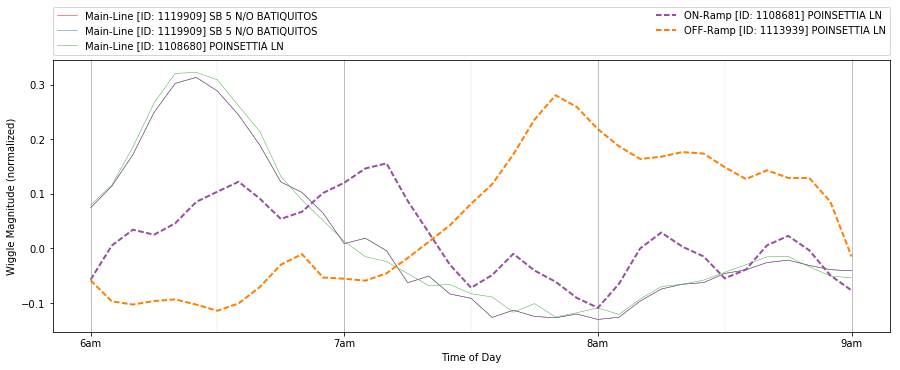

In [116]:
plot_ramp_wiggles( rampid=1113939, links=False )

### I-5 South, Encinitas Blvd. (6 - 9am) [[Google Maps]](https://www.google.com/maps/place/33.048438,-117.287351)
The on-ramp/off-ramp pair at Encinitas Blvd. also appears to service a mostly-residential area.  While the on-ramp oscillation (dashed orange line <b style='color:orange'>---</b>) minima do not always fall exactly on the hour/half-hour, the local maxima are always located _between_ the hour/half-hour marks.  In particular we see the largest spike between 7 and 7:30am, likely workers entering the highway to arrive at their workplace by 8am.

The off-ramp oscillation (dashed blue line  <b style='color:blue'>---</b>) seems to indicate some ammount of commercial activity at this location; there are identifiable local maxima just prior to each hour 7, 8, and 9am.

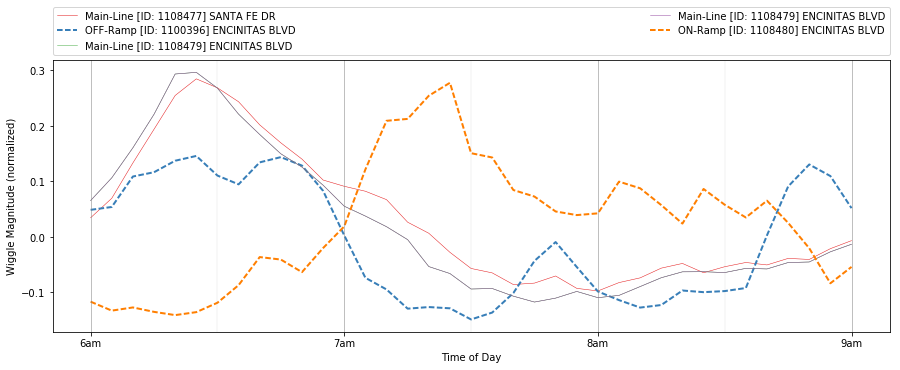

In [117]:
plot_ramp_wiggles( rampid=1100396, links=False )

### I-5 South, Lomas Santa Fe Dr. (6 - 9am) [[Google Maps]](https://www.google.com/maps/place/32.995868,-117.256708)

The on-ramp/off-ramp at Lomas Santa Fe Drive appears to have a larger commercial component than the previous stations.  An examination of the location on Google maps reveals a number of businesses and two schools immediate adjacent the highway.  Accordinly, the off-ramp oscillations (dashed blue line <b style='color:blue'>---</b>) appear to validate another part of the hypothesis.  There are local maxima in the off-ramp oscillations just prior to the hour and half-hour, consistent with workers exiting the highway just prior to typical work hours (7, 8, and 9am).

Regarding the on-ramp oscillations (dashed orange line <b style='color:orange'>---</b>), we can still see the local minima occuring at or near the hour/half-hour mark, as hypothesized.

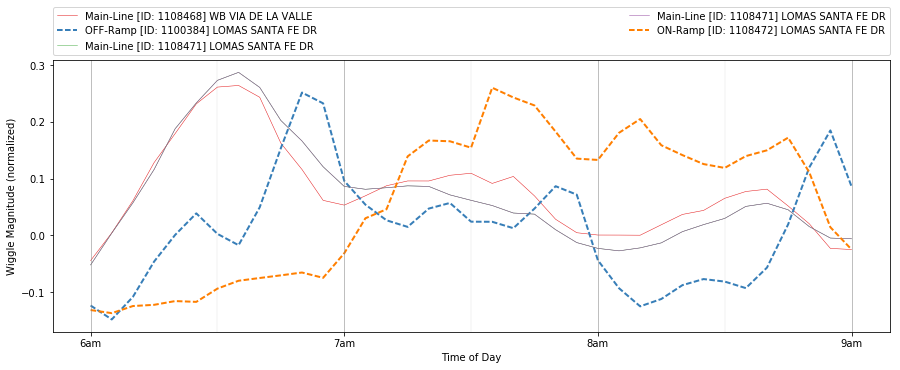

In [118]:
plot_ramp_wiggles( rampid=1100384, links=False )

### I-5 South, Clairmont Dr. (6 - 9am) [[Google Maps]](https://www.google.com/maps/place/32.791448,-117.207392)
The data subset for Clairmont Drive only includes on-ramp data and appears to be a heavily residential entrance point (Google maps).  As shown below, a portion of the hypothesis seems to hold: the on-ramp local minima are almost exactly located on the hour/half-hour marks (dashed blue line <b style='color:blue'>---</b>).  Additionally, the on-ramp flow oscillations seem to mirror the main-line flow very closely (in frequency if not magnitude).

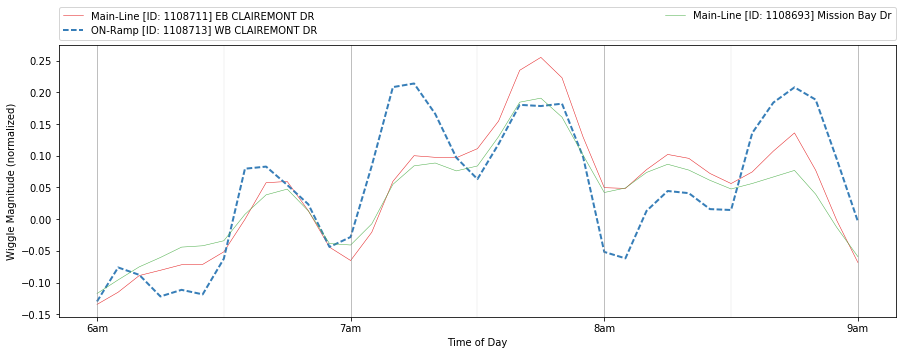

In [119]:
plot_ramp_wiggles( rampid=1108713, links=False )

### I-5 South, La Jolla Village (4 - 7pm) [[Google Maps]](https://www.google.com/maps/place/32.869675,-117.229543)
In contrast to the previous stations, the on-ramp at La Jolla Village services an area that is almost entirely commercial (also includes schools).  With this in mind, we can validate another portion of the hypothesis: evening on-ramp flow local maxima occur just after the hour/half-hour.  As the on-ramp mean flow below illustrates (dashed blue line <b style='color:blue'>---</b>), this appears to hold true (with the possible exception of the pseudo-peak just after 5:30pm).  This behavior is consistent with workers departing from there place of work after working hours (5pm for example).

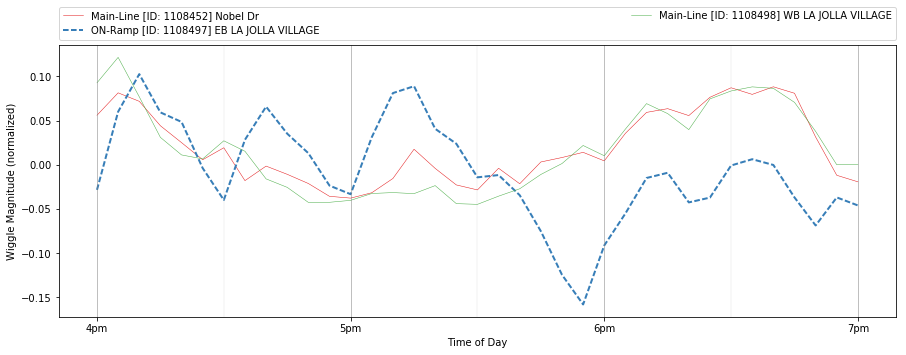

In [120]:
plot_ramp_wiggles( t_min=16, t_max=19, rampid=1108497, links=False )

### I-5 South, Old Town Ave. (4 - 7pm) [[Google Maps]](https://www.google.com/maps/place/32.746784,-117.191904)
The on-ramp/off-ramp at Old Town Ave. services a large commercial (and military, in this case) area.  In the on-ramp mean flow oscillations (dashed orange line <b style='color:orange'>---</b>), we can see a very strong set of peaks just after each hour, in addition to a set of smaller peaks at each half-hour.  As mentioned above, this is entirely consistent with workers leaving their place of business at the end of the workday.

Perhaps a bit surprisingly, the off-ramp flow (dashed green line <b style='color:green'>---</b>) appears to nearly show the inverse of the on-ramp flow (the off-ramp maxima appear to occur very close to the on-ramp minima).

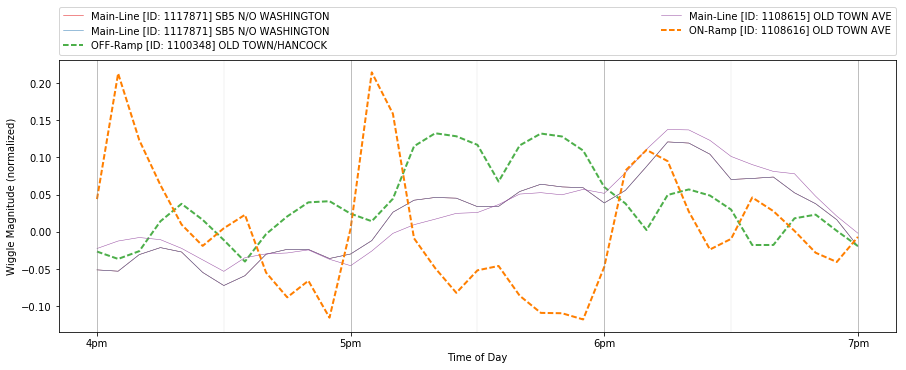

In [121]:
plot_ramp_wiggles( t_min=16, t_max=19, rampid=1100348, links=False )

### I-5 South, Mission Ave. (6 - 9am) [[Google Maps]](https://www.google.com/maps/place/33.200618,-117.373434)
Perhaps one of the most interesting exit/entrance points on our sample highway is located at Mission Ave.  This pair of on-ramp/off-ramps services a residential-heavy area.  Accordingly, the on-ramp mean flow (dashed purple line <b style='color:purple'>---</b>) follows the hypothesis with local minima at (or near) the hour/half-hour marks.

However, there is a rather unexpected large spike in the off-ramp mean oscillation (dashed orange line <b style='color:orange'>---</b> between 7 and 7:30am) even while the remainder of the line is relatively free from oscillations.

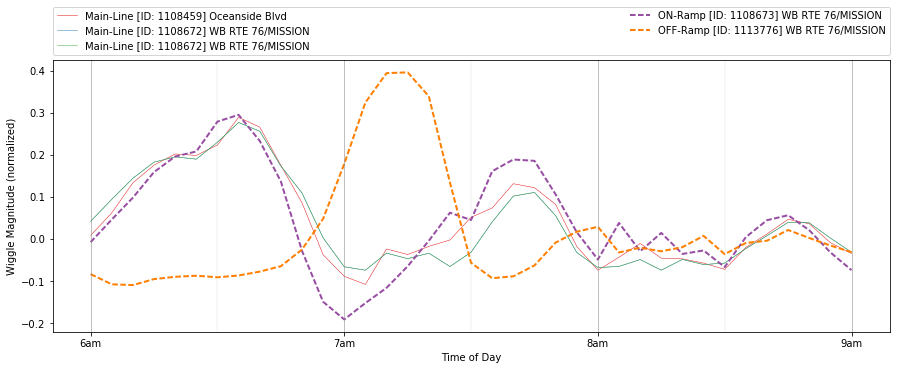

In [122]:
plot_ramp_wiggles( rampid=1113776, links=False )

### I-5 South, Mission Ave., Oceanside High School  [[Google Maps]](https://www.google.com/maps/place/33.200618,-117.373434)

As it would turn out, the Mission Ave. exit leads directly to Oceanside High School.  Additional investigation reveals that the first period at this school starts at 7:30am. [[Oceanside HS Bell Schedule]](https://ohs-ousd-ca.schoolloop.com/BellSchedule)

This appears to explain the spike in off-ramp traffic at this location just prior to 7:30am; students are arriving at the school before the first period.

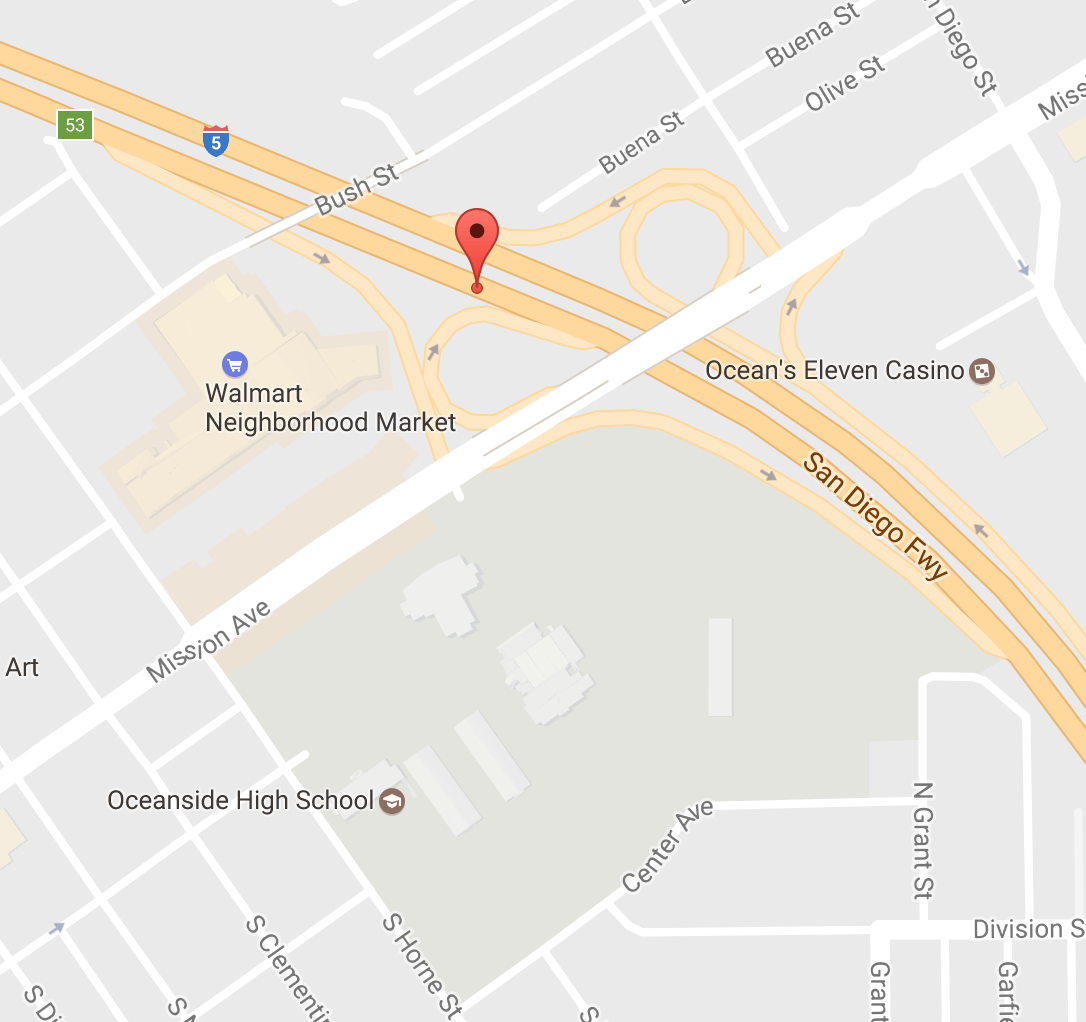

In [69]:
Image("oceanside_highschool.png", width=400)

On-ramp and off-ramp mean flow data exhibit patterns (oscillations) which can be correlated to oscillations in the mean flow of the main-line (eg. phase shifted).  In particular we hypothesis the following are true:
- Areas of high commercial concentration will experience peaks in the off-ramp oscillations just _prior to_ the hour and half-hour during the _morning_ hours.
- These same commercial-heavy areas will experience peaks in on-ramp oscillations just _after_ the hour and half-hour during the _evening_ hours.
- Areas of high residential concentration will experience valleys in the on-ramp oscillations near the hour and half-hour during the _morning_ hours.

### Results

The juxtaposition of the on-ramp/off-ramp oscillations and the main-line oscillations produced some interesting results.  While the hypotheses are not strongly exhibited in every station, they do appear to be at least partially represented.  Additionally, highly homogenous areas (residential, commercial) appear to show the posited behaviors quite well.

Also, residential area on-ramp (mornings) and off-ramp (evenings) flow does not appear as stark as commercial areas.   This is potentially because workers have varying commute times and likely leave for work (and arrive home) at differing times.

### Conclusions

While perhaps not a rigorous proof, the ramp-vs-main-line graphs are compelling none the less.  There appears to be a correlation between the on-ramp/off-ramp flow and main-line flow that indicates the main-line oscillations are not an artifact of the data collection process.

To further explore this relationship, some potential additional steps may include the following:

- Filter the data by weekday-only
- Include both north _and_ south directions
- Analyze additional highways

OR [54.292] 1122250 - SB 5 @ HARBOR DR https://www.google.com/maps/place/33.210909,-117.387715
FR [54.292] 1122252 - SB 5 @ HARBOR DR https://www.google.com/maps/place/33.210909,-117.387715


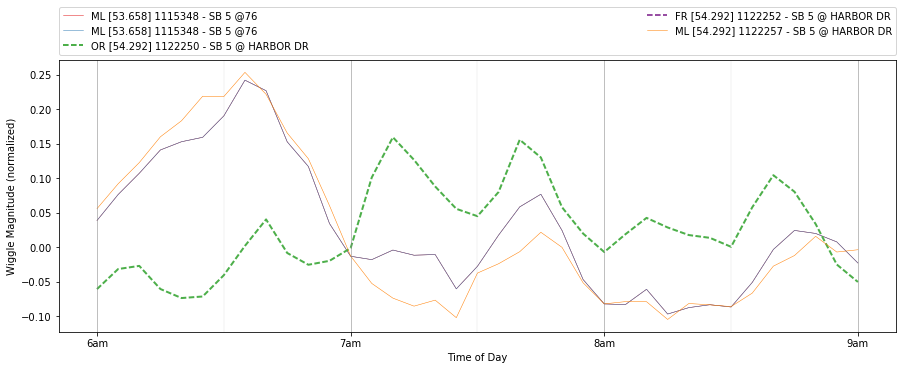

OR [54.292] 1122250 - SB 5 @ HARBOR DR https://www.google.com/maps/place/33.210909,-117.387715
FR [54.292] 1122252 - SB 5 @ HARBOR DR https://www.google.com/maps/place/33.210909,-117.387715


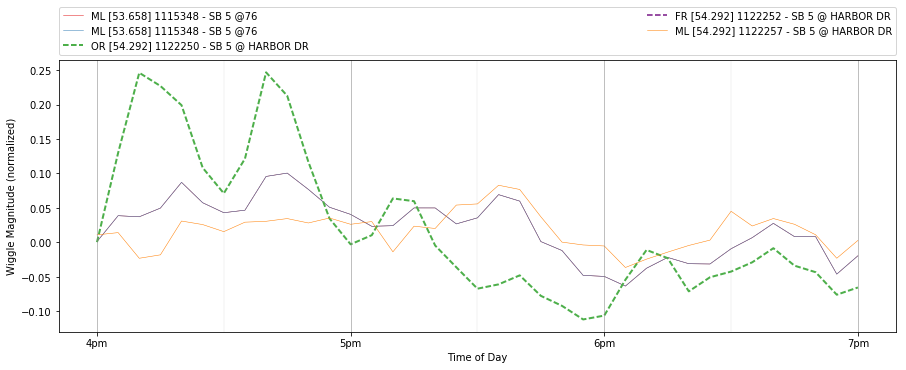

OR [53.159] 1108674 - EB RTE 76/MISSION https://www.google.com/maps/place/33.200623,-117.37345


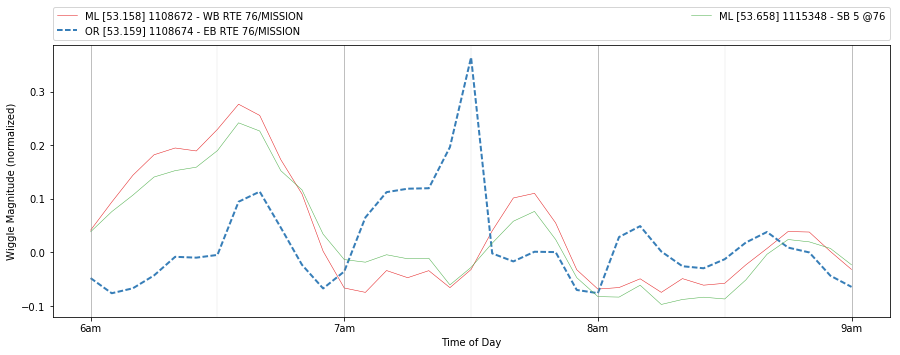

OR [53.159] 1108674 - EB RTE 76/MISSION https://www.google.com/maps/place/33.200623,-117.37345


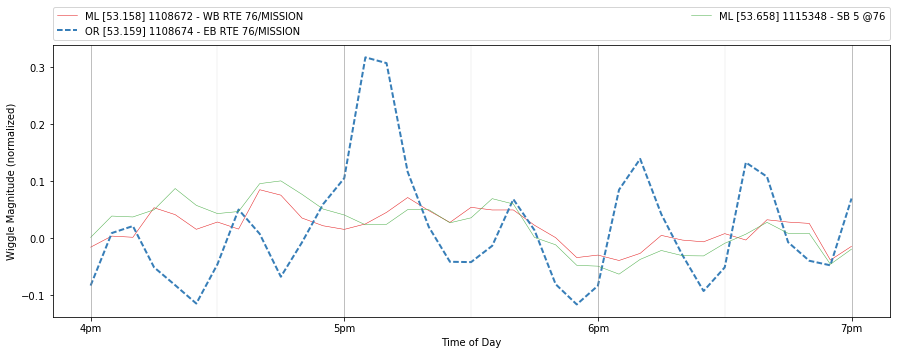

OR [53.159] 1108674 - EB RTE 76/MISSION https://www.google.com/maps/place/33.200623,-117.37345


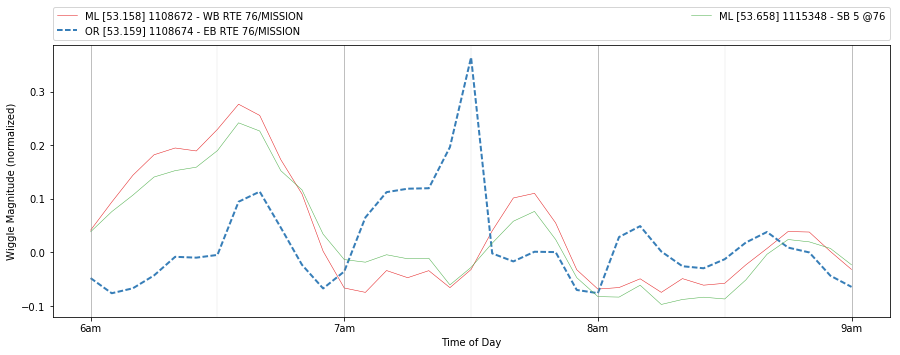

OR [53.159] 1108674 - EB RTE 76/MISSION https://www.google.com/maps/place/33.200623,-117.37345


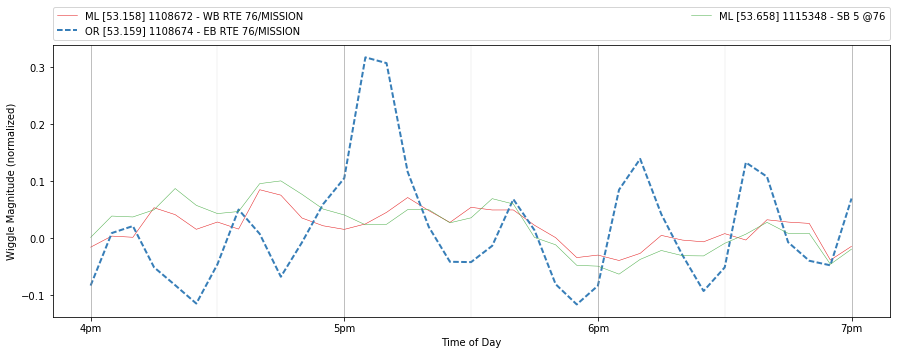

OR [52.266] 1108460 - OCEANSIDE BLVD https://www.google.com/maps/place/33.191277,-117.363281
FR [52.266] 1113780 - OCEANSIDE BLVD https://www.google.com/maps/place/33.191277,-117.363281


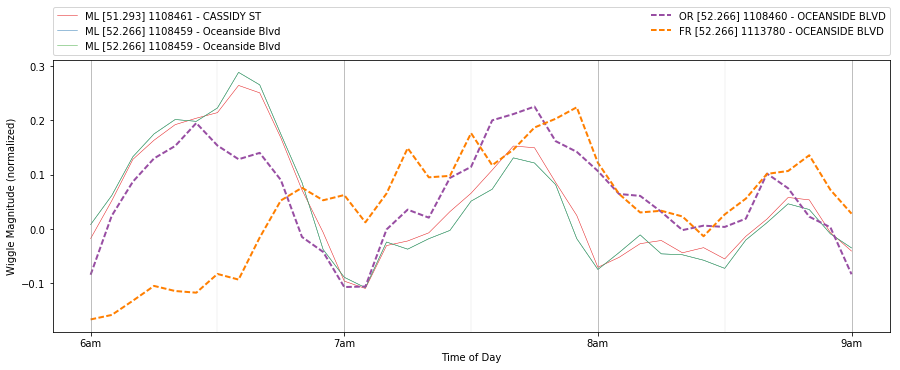

OR [52.266] 1108460 - OCEANSIDE BLVD https://www.google.com/maps/place/33.191277,-117.363281
FR [52.266] 1113780 - OCEANSIDE BLVD https://www.google.com/maps/place/33.191277,-117.363281


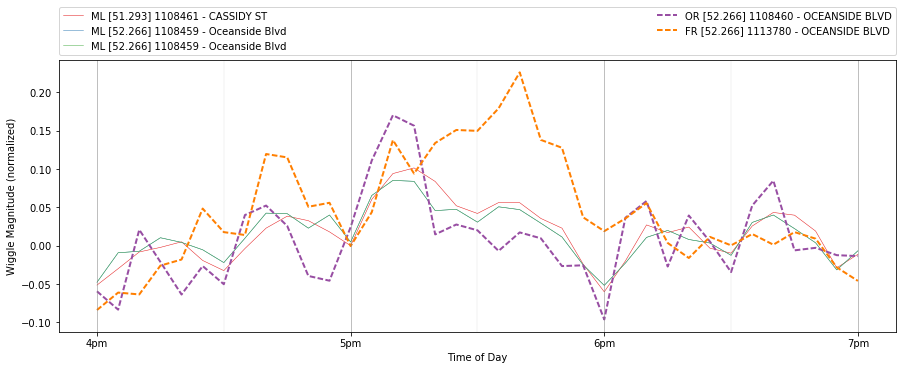

OR [52.266] 1108460 - OCEANSIDE BLVD https://www.google.com/maps/place/33.191277,-117.363281
FR [52.266] 1113780 - OCEANSIDE BLVD https://www.google.com/maps/place/33.191277,-117.363281


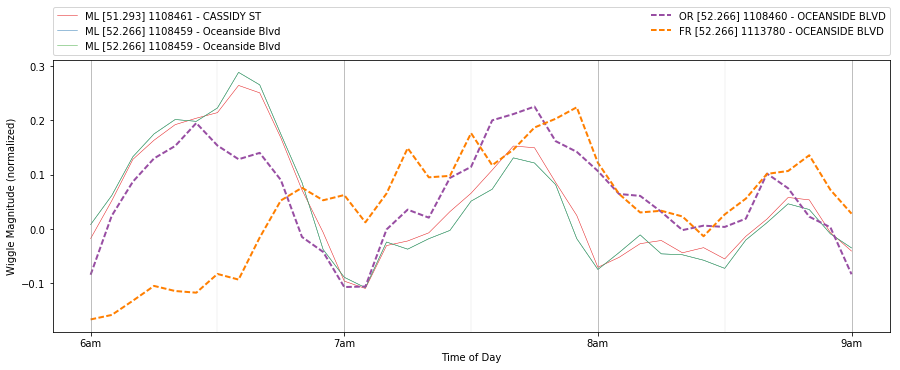

OR [52.266] 1108460 - OCEANSIDE BLVD https://www.google.com/maps/place/33.191277,-117.363281
FR [52.266] 1113780 - OCEANSIDE BLVD https://www.google.com/maps/place/33.191277,-117.363281


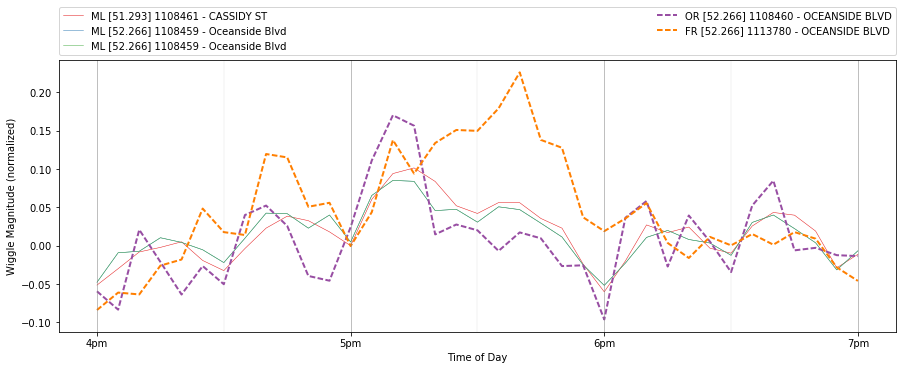

FR [51.271] 1113782 - CASSIDY ST https://www.google.com/maps/place/33.179471,-117.353435


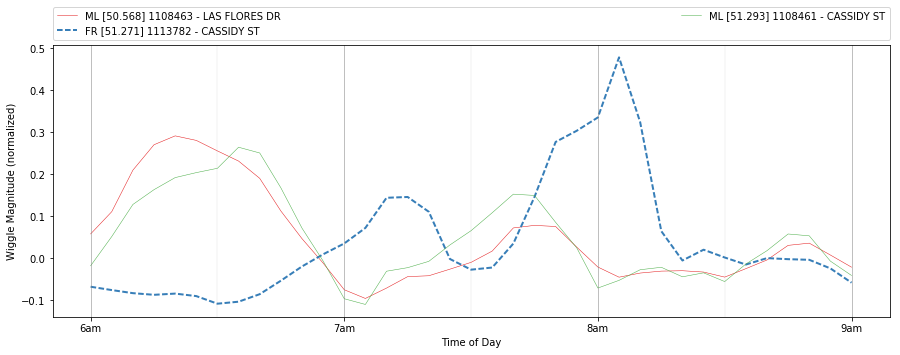

FR [51.271] 1113782 - CASSIDY ST https://www.google.com/maps/place/33.179471,-117.353435


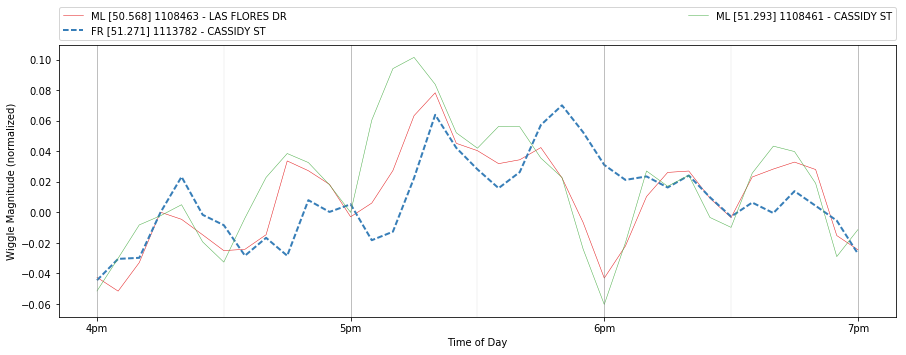

OR [50.568] 1108464 - LAS FLORES DR https://www.google.com/maps/place/33.17092,-117.346811
FR [50.568] 1113788 - LAS FLORES DR https://www.google.com/maps/place/33.17092,-117.346811


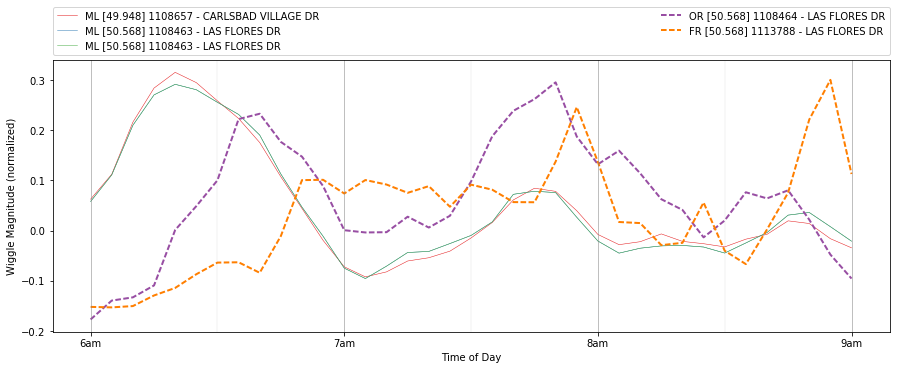

OR [50.568] 1108464 - LAS FLORES DR https://www.google.com/maps/place/33.17092,-117.346811
FR [50.568] 1113788 - LAS FLORES DR https://www.google.com/maps/place/33.17092,-117.346811


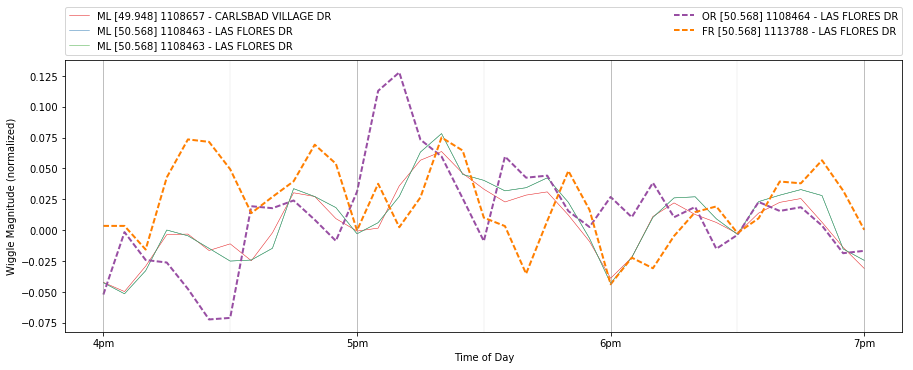

OR [49.948] 1108658 - CARLSBAD VILLAGE DR https://www.google.com/maps/place/33.162818,-117.342266
FR [49.948] 1113791 - CARLSBAD VILLAGE DR https://www.google.com/maps/place/33.162818,-117.342266


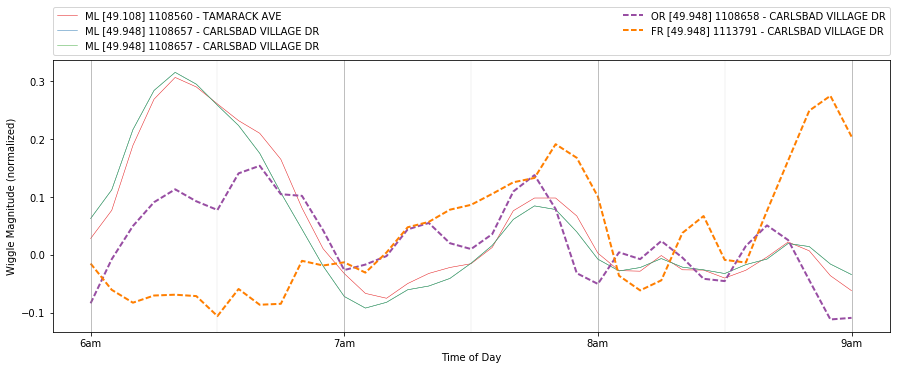

OR [49.948] 1108658 - CARLSBAD VILLAGE DR https://www.google.com/maps/place/33.162818,-117.342266
FR [49.948] 1113791 - CARLSBAD VILLAGE DR https://www.google.com/maps/place/33.162818,-117.342266


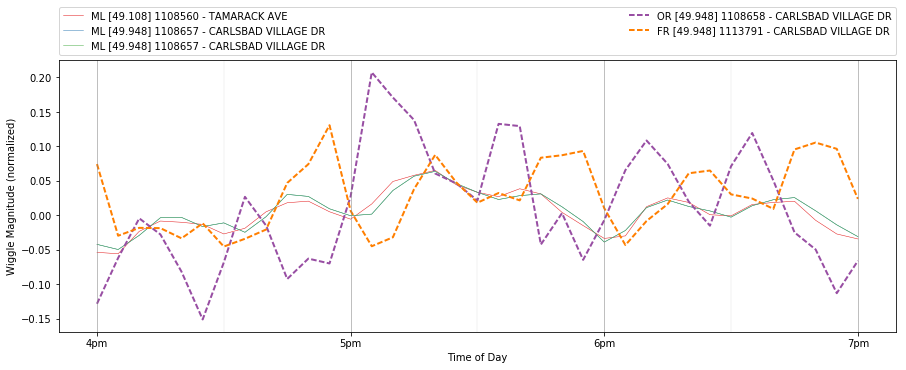

OR [49.948] 1108658 - CARLSBAD VILLAGE DR https://www.google.com/maps/place/33.162818,-117.342266
FR [49.948] 1113791 - CARLSBAD VILLAGE DR https://www.google.com/maps/place/33.162818,-117.342266


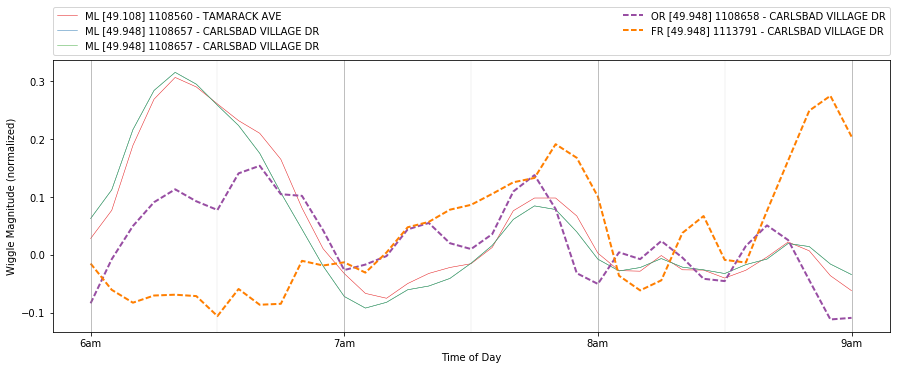

OR [49.948] 1108658 - CARLSBAD VILLAGE DR https://www.google.com/maps/place/33.162818,-117.342266
FR [49.948] 1113791 - CARLSBAD VILLAGE DR https://www.google.com/maps/place/33.162818,-117.342266


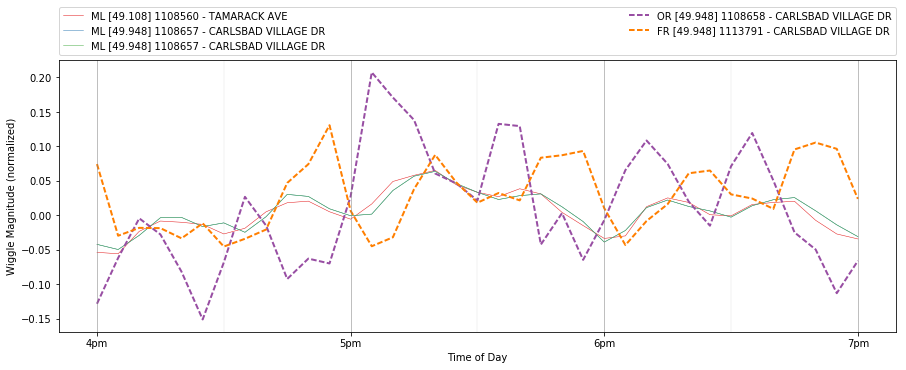

OR [47.823] 1108662 - CANNON RD https://www.google.com/maps/place/33.134215,-117.329382
FR [47.823] 1113797 - CANNON RD https://www.google.com/maps/place/33.134215,-117.329382


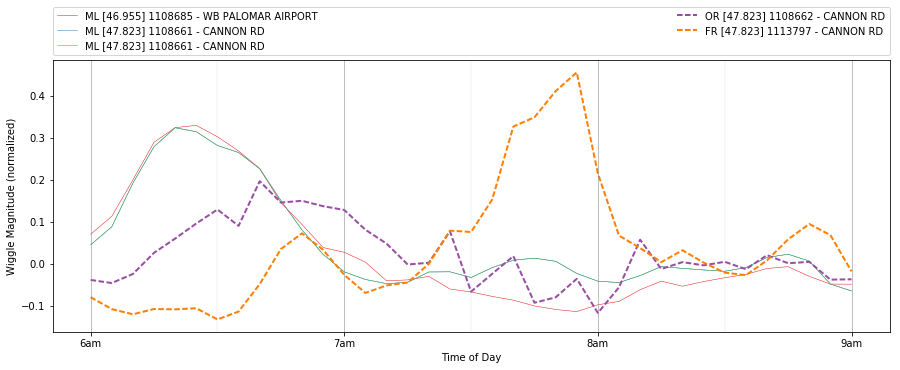

OR [47.823] 1108662 - CANNON RD https://www.google.com/maps/place/33.134215,-117.329382
FR [47.823] 1113797 - CANNON RD https://www.google.com/maps/place/33.134215,-117.329382


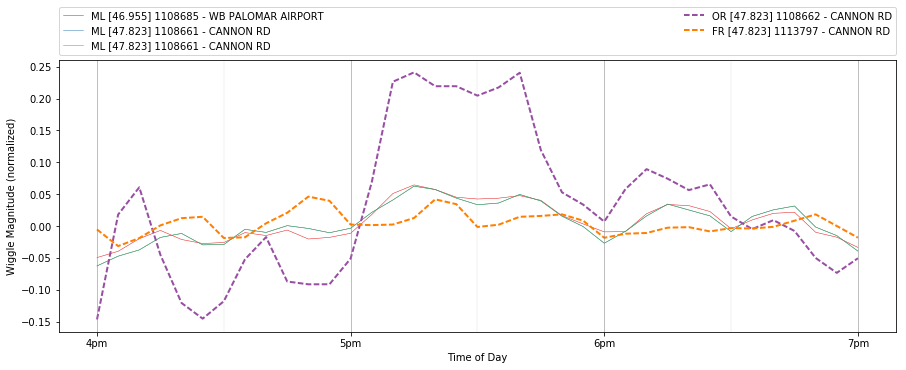

OR [47.823] 1108662 - CANNON RD https://www.google.com/maps/place/33.134215,-117.329382
FR [47.823] 1113797 - CANNON RD https://www.google.com/maps/place/33.134215,-117.329382


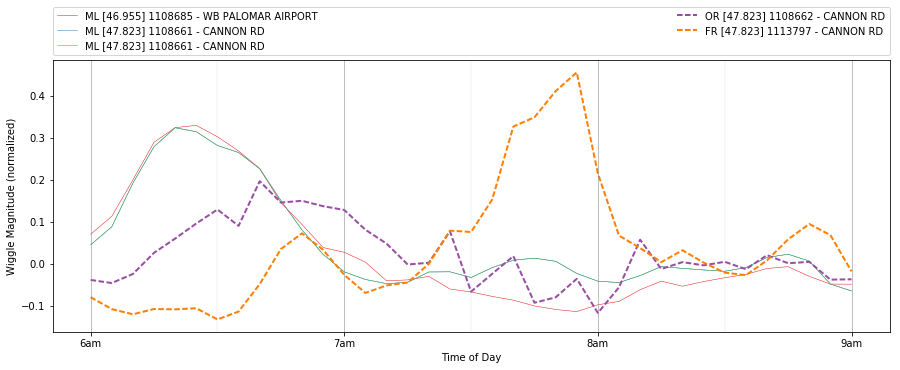

OR [47.823] 1108662 - CANNON RD https://www.google.com/maps/place/33.134215,-117.329382
FR [47.823] 1113797 - CANNON RD https://www.google.com/maps/place/33.134215,-117.329382


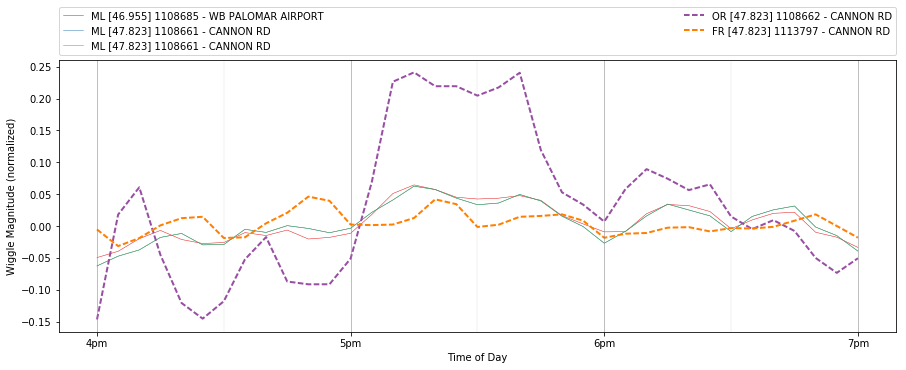

OR [46.727] 1108684 - EB PALOMAR AIRPORT https://www.google.com/maps/place/33.120034,-117.320913


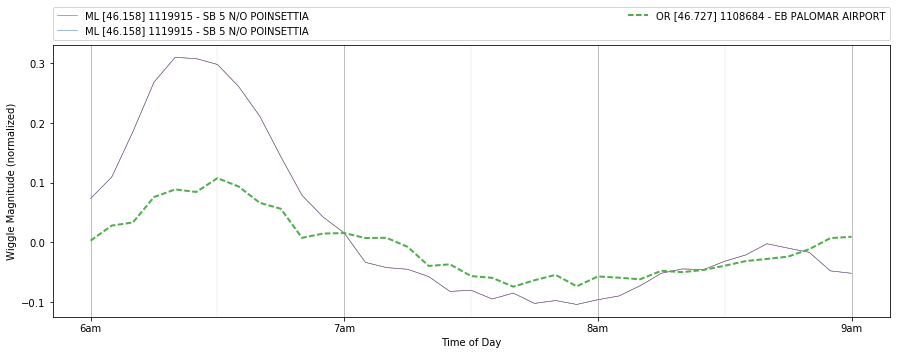

OR [46.727] 1108684 - EB PALOMAR AIRPORT https://www.google.com/maps/place/33.120034,-117.320913


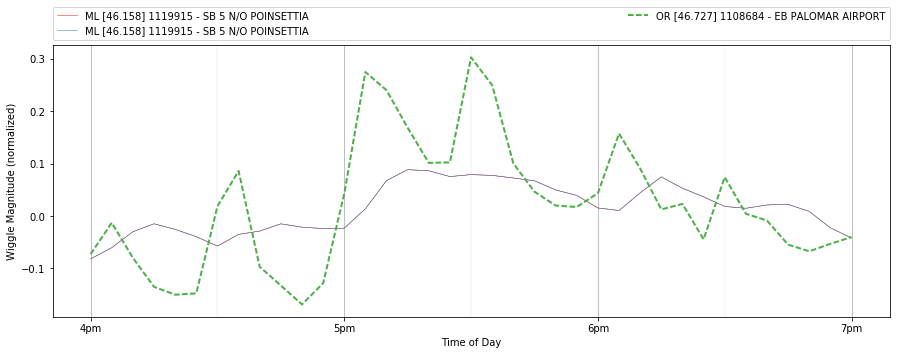

OR [45.293] 1108681 - POINSETTIA LN https://www.google.com/maps/place/33.101626,-117.309439
FR [45.293] 1113939 - POINSETTIA LN https://www.google.com/maps/place/33.101626,-117.309439


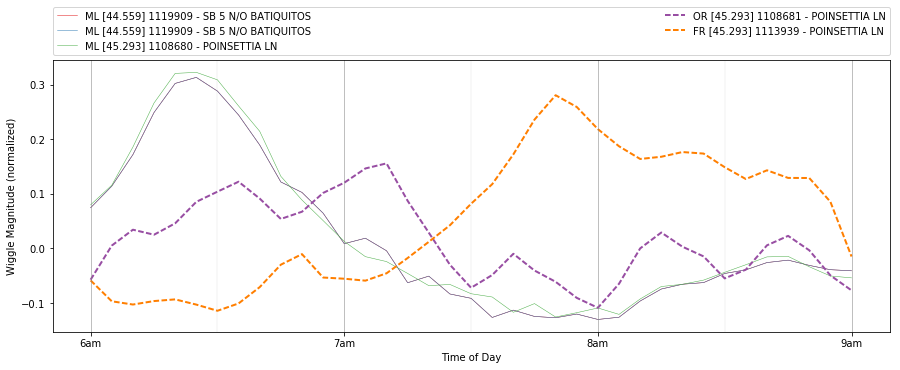

OR [45.293] 1108681 - POINSETTIA LN https://www.google.com/maps/place/33.101626,-117.309439
FR [45.293] 1113939 - POINSETTIA LN https://www.google.com/maps/place/33.101626,-117.309439


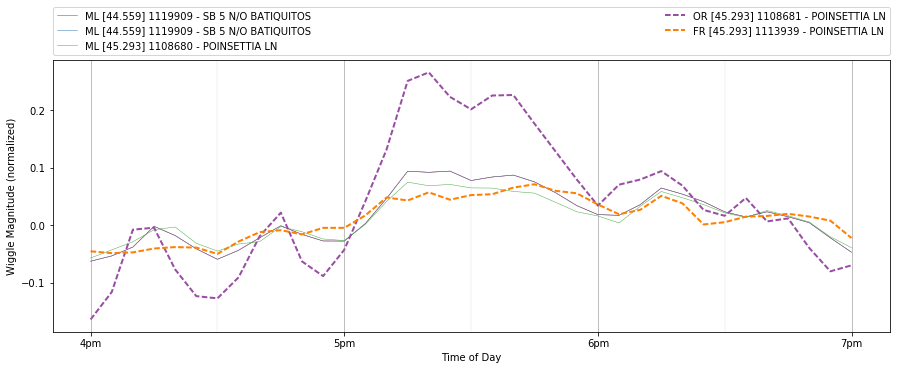

OR [43.643] 1108726 - LA COSTA AVE https://www.google.com/maps/place/33.080188,-117.296877
FR [43.643] 1113803 - LA COSTA AVE https://www.google.com/maps/place/33.080188,-117.296877


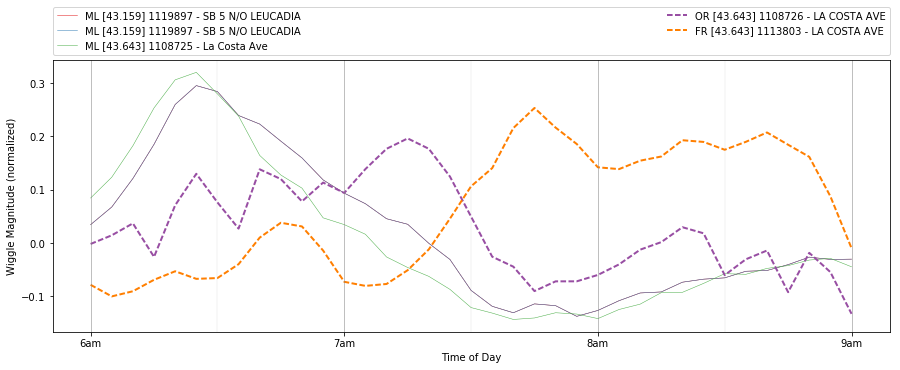

OR [43.643] 1108726 - LA COSTA AVE https://www.google.com/maps/place/33.080188,-117.296877
FR [43.643] 1113803 - LA COSTA AVE https://www.google.com/maps/place/33.080188,-117.296877


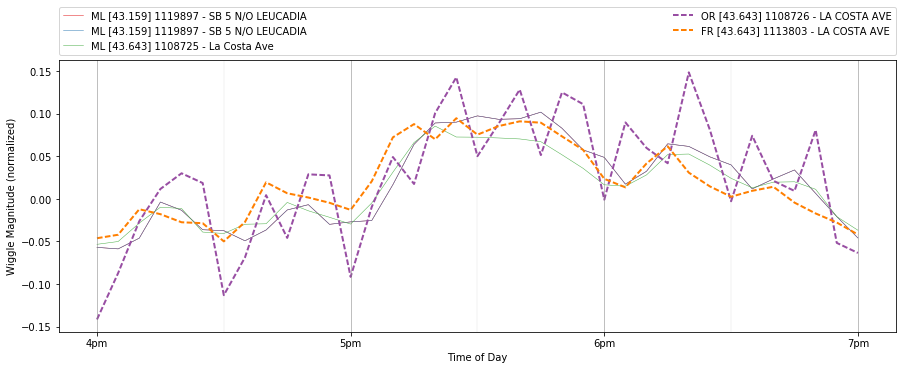

OR [42.548] 1108724 - LEUCADIA BLVD https://www.google.com/maps/place/33.064772,-117.292309
FR [42.548] 1113960 - LEUCADIA BLVD https://www.google.com/maps/place/33.064772,-117.292309


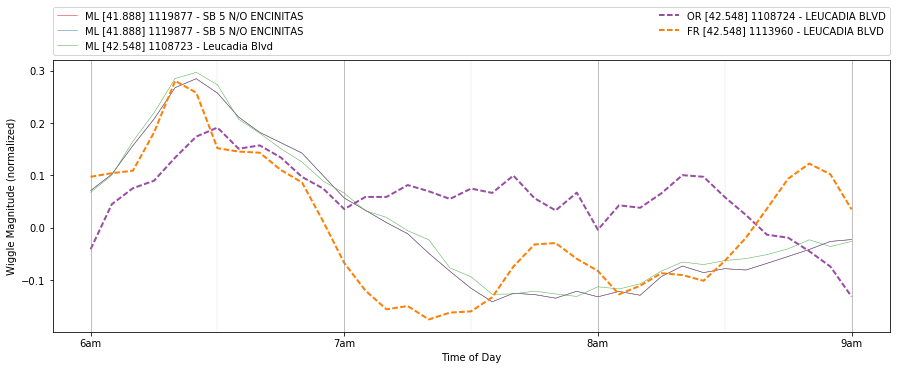

OR [42.548] 1108724 - LEUCADIA BLVD https://www.google.com/maps/place/33.064772,-117.292309
FR [42.548] 1113960 - LEUCADIA BLVD https://www.google.com/maps/place/33.064772,-117.292309


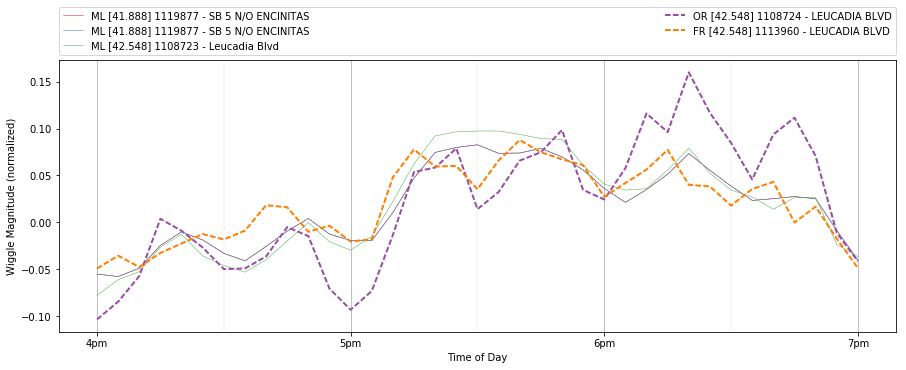

FR [41.385] 1100396 - ENCINITAS BLVD https://www.google.com/maps/place/33.048438,-117.287351
OR [41.385] 1108480 - ENCINITAS BLVD https://www.google.com/maps/place/33.048438,-117.287351


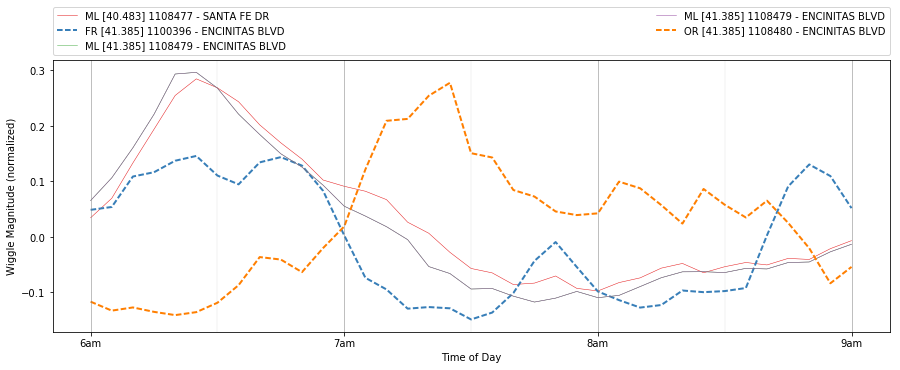

FR [41.385] 1100396 - ENCINITAS BLVD https://www.google.com/maps/place/33.048438,-117.287351
OR [41.385] 1108480 - ENCINITAS BLVD https://www.google.com/maps/place/33.048438,-117.287351


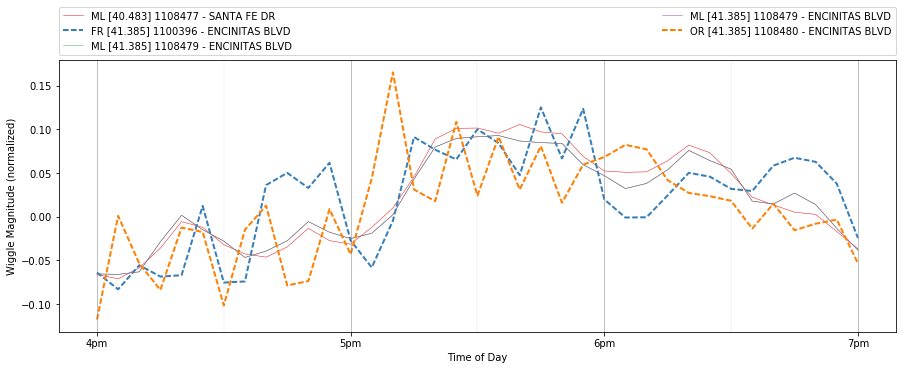

FR [40.483] 1100393 - SANTA FE DR https://www.google.com/maps/place/33.036347,-117.281649
OR [40.483] 1108478 - SANTA FE DR https://www.google.com/maps/place/33.036347,-117.281649


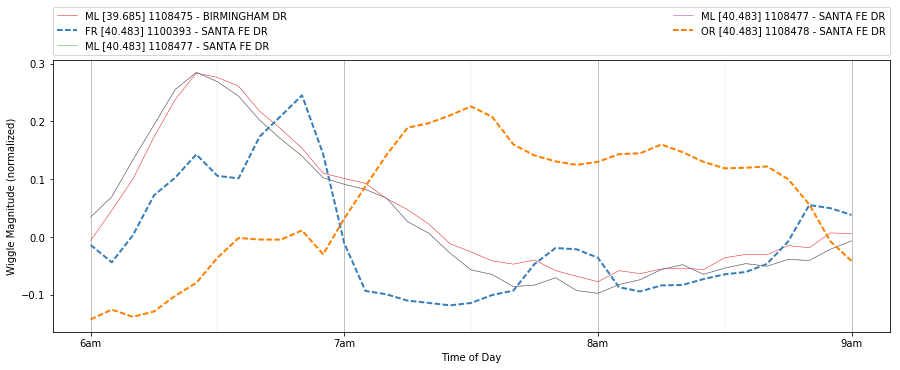

FR [40.483] 1100393 - SANTA FE DR https://www.google.com/maps/place/33.036347,-117.281649
OR [40.483] 1108478 - SANTA FE DR https://www.google.com/maps/place/33.036347,-117.281649


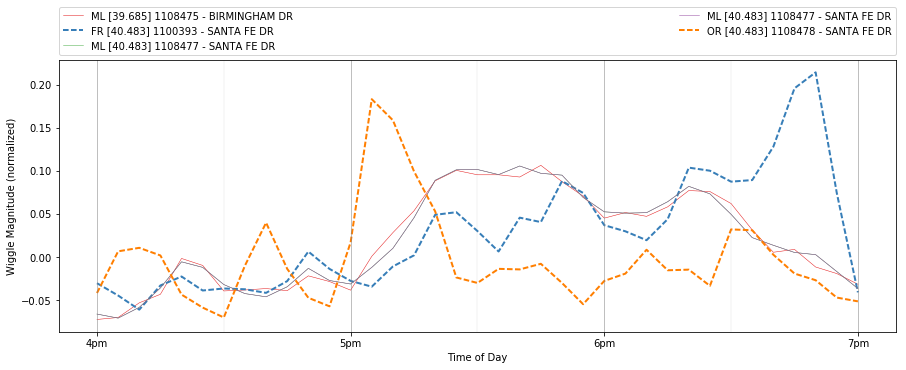

FR [40.483] 1100393 - SANTA FE DR https://www.google.com/maps/place/33.036347,-117.281649
OR [40.483] 1108478 - SANTA FE DR https://www.google.com/maps/place/33.036347,-117.281649


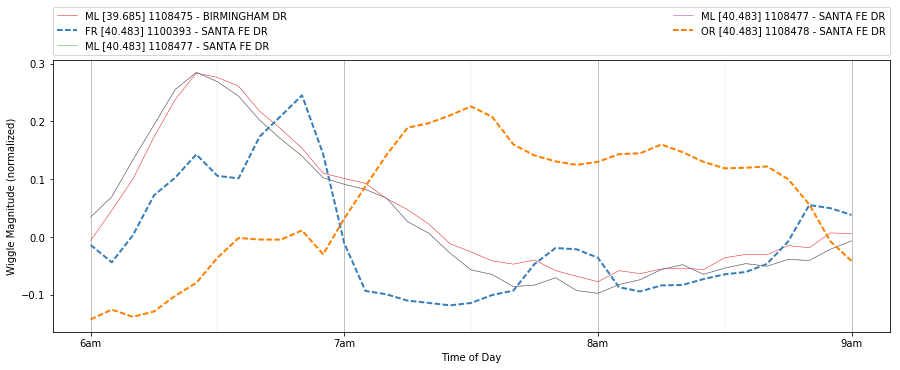

FR [40.483] 1100393 - SANTA FE DR https://www.google.com/maps/place/33.036347,-117.281649
OR [40.483] 1108478 - SANTA FE DR https://www.google.com/maps/place/33.036347,-117.281649


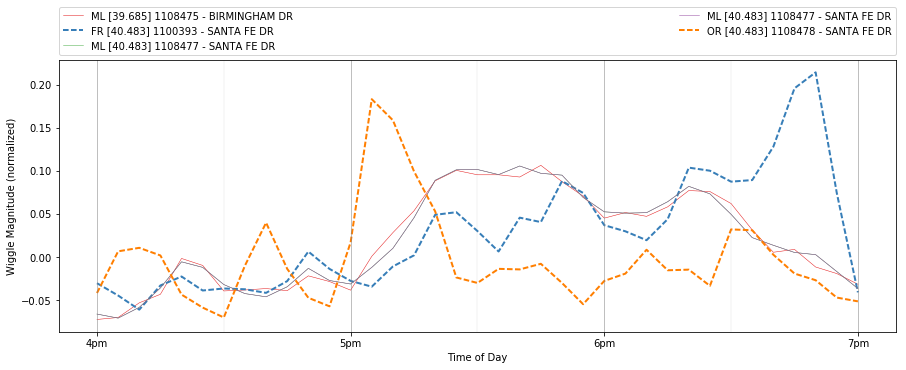

FR [38.439] 1100387 - MANCHESTER AVE https://www.google.com/maps/place/33.010643,-117.265228
OR [38.439] 1108474 - MANCHESTER AVE https://www.google.com/maps/place/33.010643,-117.265228


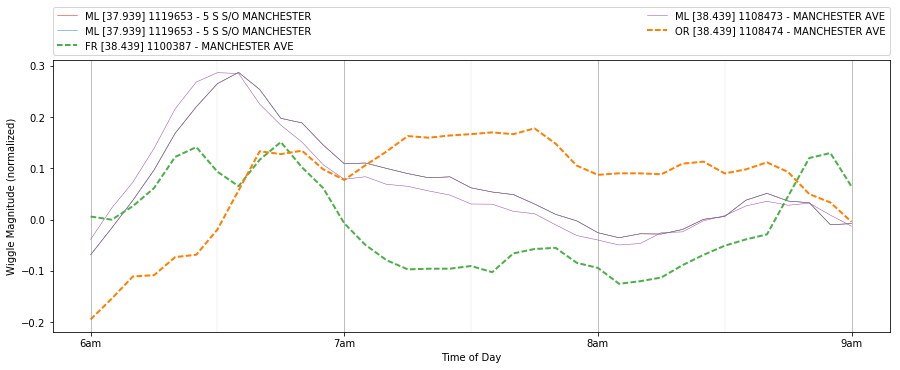

FR [38.439] 1100387 - MANCHESTER AVE https://www.google.com/maps/place/33.010643,-117.265228
OR [38.439] 1108474 - MANCHESTER AVE https://www.google.com/maps/place/33.010643,-117.265228


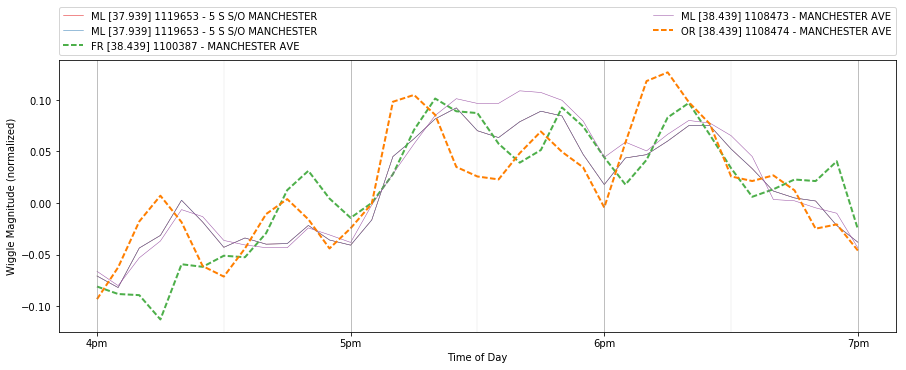

OR [37.257] 1120740 - SB5 Lomas San Fe EB https://www.google.com/maps/place/32.995897,-117.256712


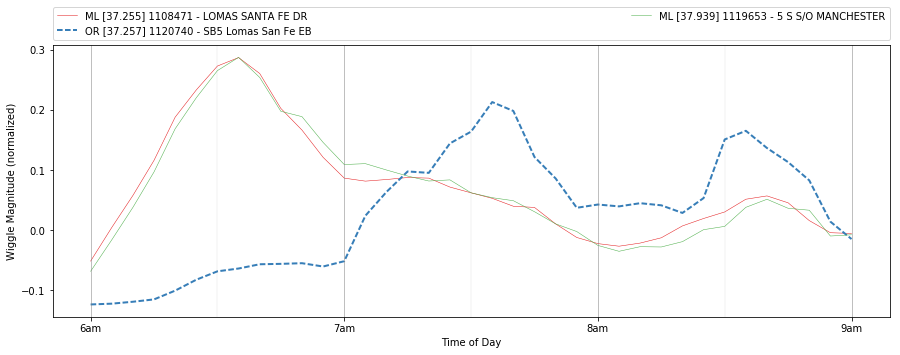

OR [37.257] 1120740 - SB5 Lomas San Fe EB https://www.google.com/maps/place/32.995897,-117.256712


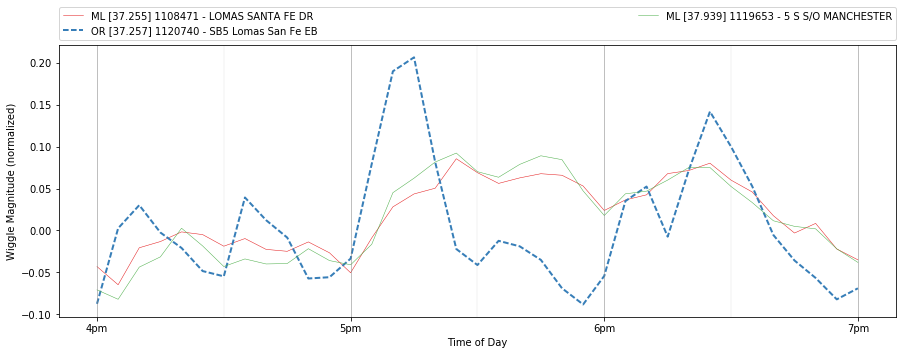

FR [37.255] 1100384 - LOMAS SANTA FE DR https://www.google.com/maps/place/32.995868,-117.256708
OR [37.255] 1108472 - LOMAS SANTA FE DR https://www.google.com/maps/place/32.995868,-117.256708


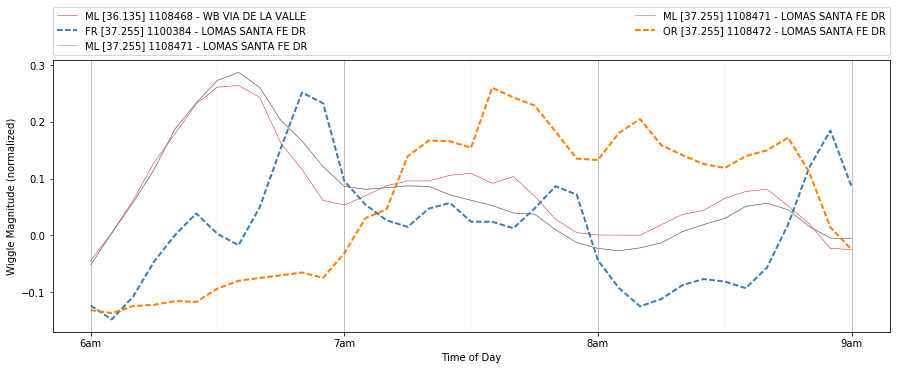

FR [37.255] 1100384 - LOMAS SANTA FE DR https://www.google.com/maps/place/32.995868,-117.256708
OR [37.255] 1108472 - LOMAS SANTA FE DR https://www.google.com/maps/place/32.995868,-117.256708


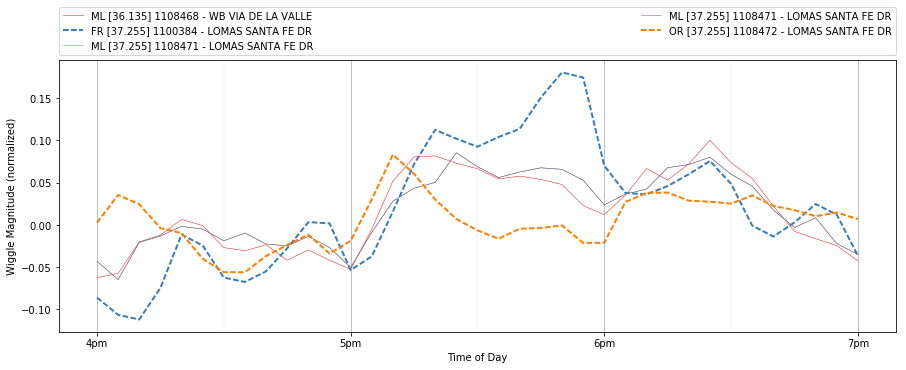

FR [36.135] 1100381 - VIA DE LA VALLE https://www.google.com/maps/place/32.979922,-117.253241
OR [36.135] 1108469 - WB VIA DE LA VALLE https://www.google.com/maps/place/32.979922,-117.253241


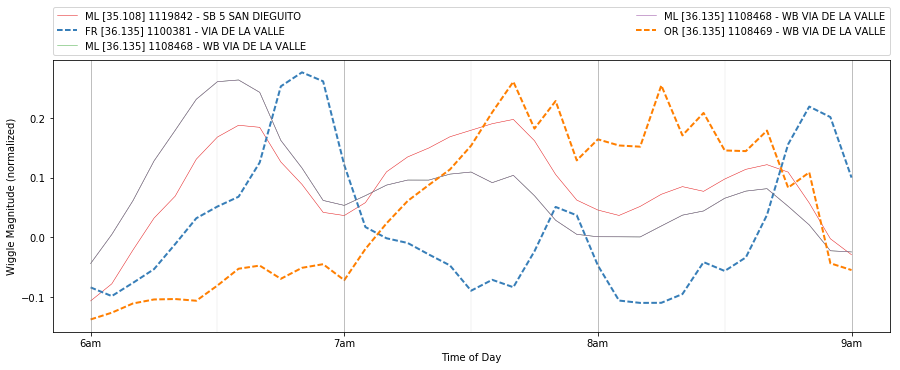

FR [36.135] 1100381 - VIA DE LA VALLE https://www.google.com/maps/place/32.979922,-117.253241
OR [36.135] 1108469 - WB VIA DE LA VALLE https://www.google.com/maps/place/32.979922,-117.253241


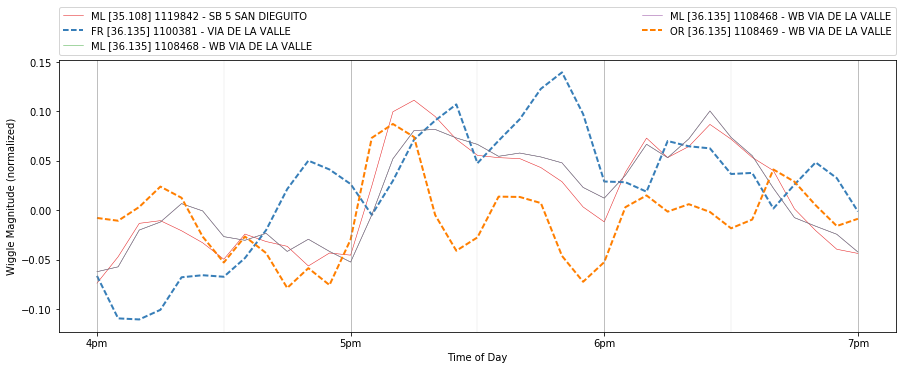

OR [36.133] 1108470 - EB VIA DE LA VALLE https://www.google.com/maps/place/32.979894,-117.25323


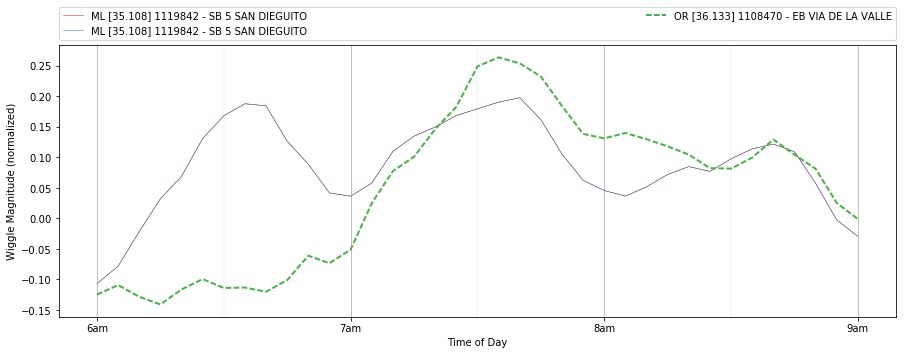

OR [36.133] 1108470 - EB VIA DE LA VALLE https://www.google.com/maps/place/32.979894,-117.25323


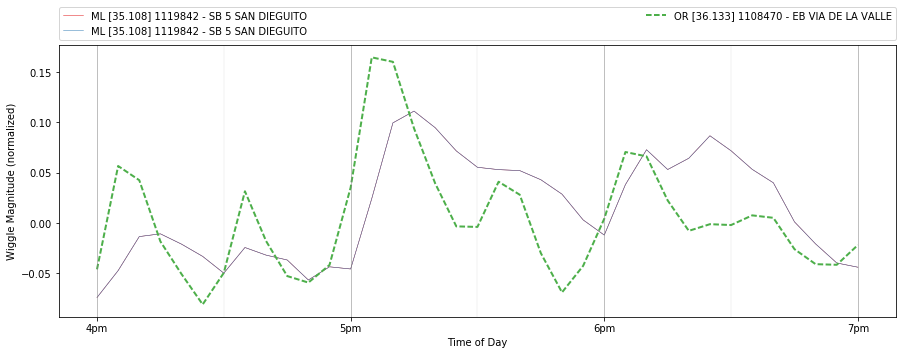

FR [34.169] 1100377 - DEL MAR HEIGHTS RD https://www.google.com/maps/place/32.952468,-117.244298
OR [34.169] 1108432 - WB DEL MAR HEIGHTS https://www.google.com/maps/place/32.952468,-117.244298


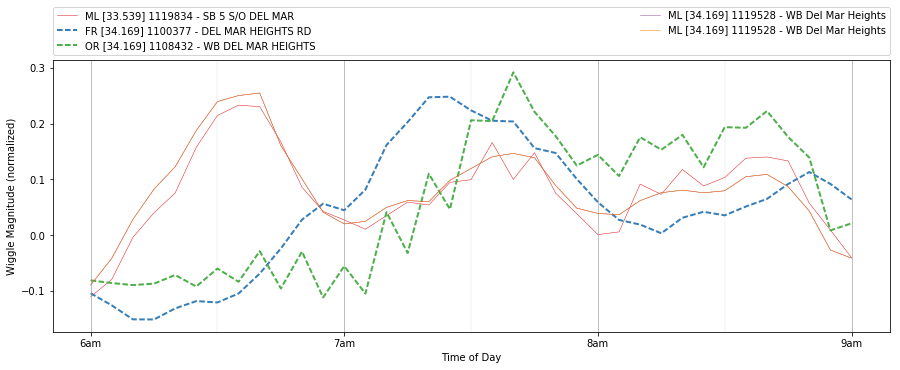

FR [34.169] 1100377 - DEL MAR HEIGHTS RD https://www.google.com/maps/place/32.952468,-117.244298
OR [34.169] 1108432 - WB DEL MAR HEIGHTS https://www.google.com/maps/place/32.952468,-117.244298


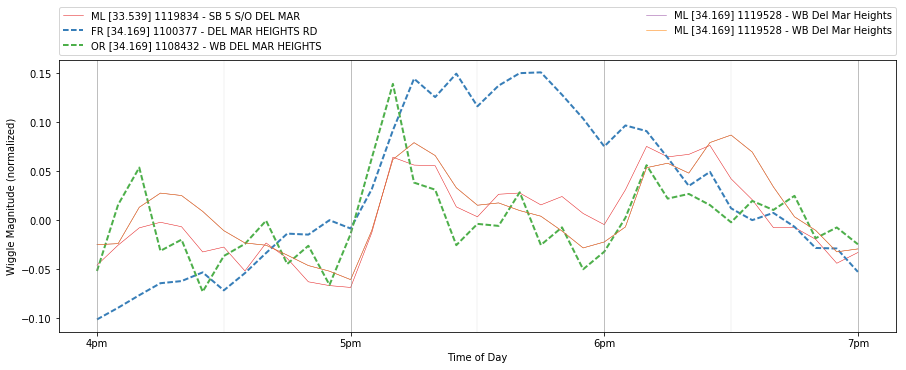

OR [34.159] 1108433 - EB DEL MAR HEIGHTS https://www.google.com/maps/place/32.952324,-117.244271


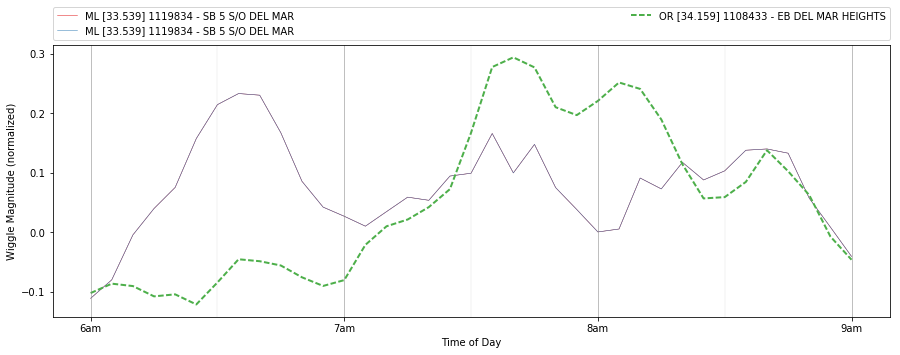

OR [34.159] 1108433 - EB DEL MAR HEIGHTS https://www.google.com/maps/place/32.952324,-117.244271


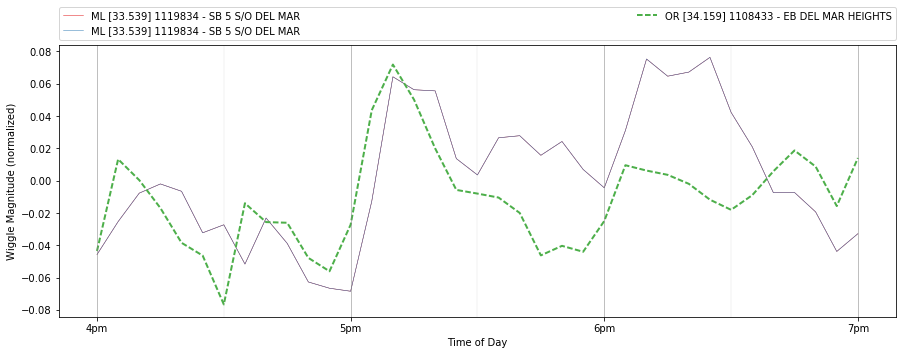

FR [32.663] 1100372 - CARMEL VALLEY RD https://www.google.com/maps/place/32.930855,-117.241058
OR [32.663] 1108435 - CARMEL VALLEY RD https://www.google.com/maps/place/32.930855,-117.241058


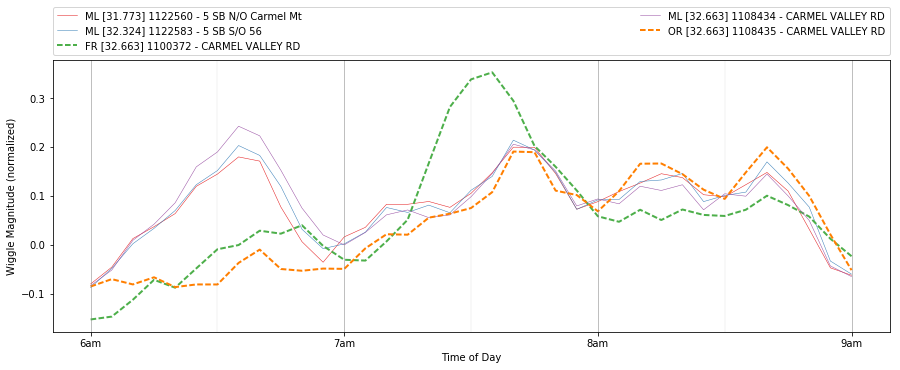

FR [32.663] 1100372 - CARMEL VALLEY RD https://www.google.com/maps/place/32.930855,-117.241058
OR [32.663] 1108435 - CARMEL VALLEY RD https://www.google.com/maps/place/32.930855,-117.241058


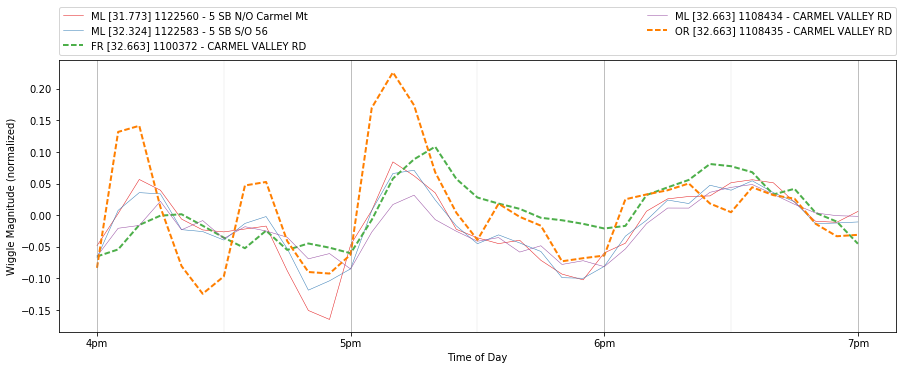

OR [31.517] 1118152 - Carmel Mt. To SB 5 https://www.google.com/maps/place/32.91625,-117.232541
FR [31.517] 1120749 - Carmel Mt. To SB 5 https://www.google.com/maps/place/32.91625,-117.232541


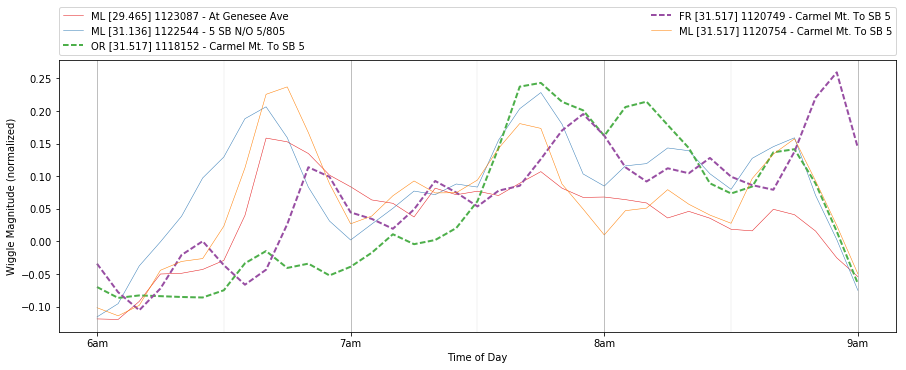

OR [31.517] 1118152 - Carmel Mt. To SB 5 https://www.google.com/maps/place/32.91625,-117.232541
FR [31.517] 1120749 - Carmel Mt. To SB 5 https://www.google.com/maps/place/32.91625,-117.232541


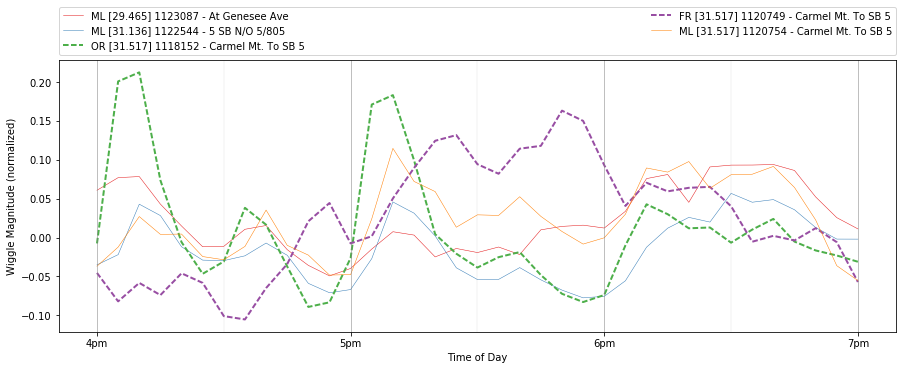

FR [28.355] 1100369 - LA JOLLA VILLAGE DR https://www.google.com/maps/place/32.87259,-117.229295
OR [28.355] 1108499 - WB LA JOLLA VILLAGE https://www.google.com/maps/place/32.87259,-117.229295


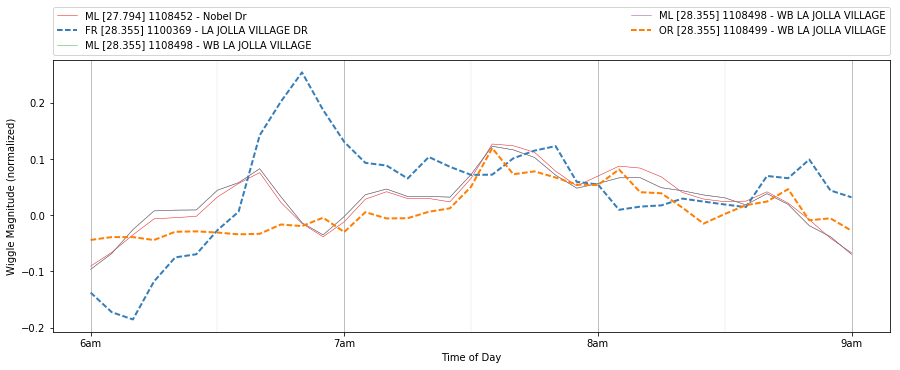

FR [28.355] 1100369 - LA JOLLA VILLAGE DR https://www.google.com/maps/place/32.87259,-117.229295
OR [28.355] 1108499 - WB LA JOLLA VILLAGE https://www.google.com/maps/place/32.87259,-117.229295


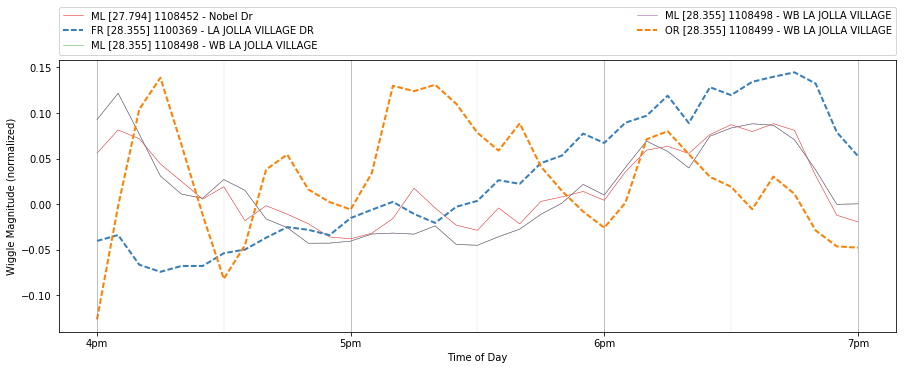

OR [28.152] 1108497 - EB LA JOLLA VILLAGE https://www.google.com/maps/place/32.869675,-117.229543


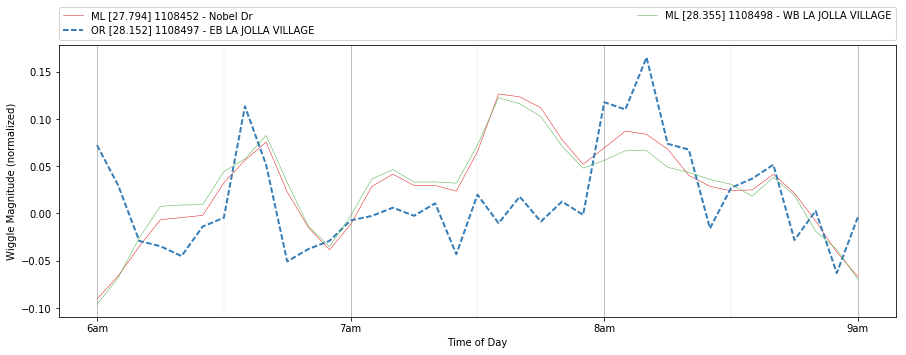

OR [28.152] 1108497 - EB LA JOLLA VILLAGE https://www.google.com/maps/place/32.869675,-117.229543


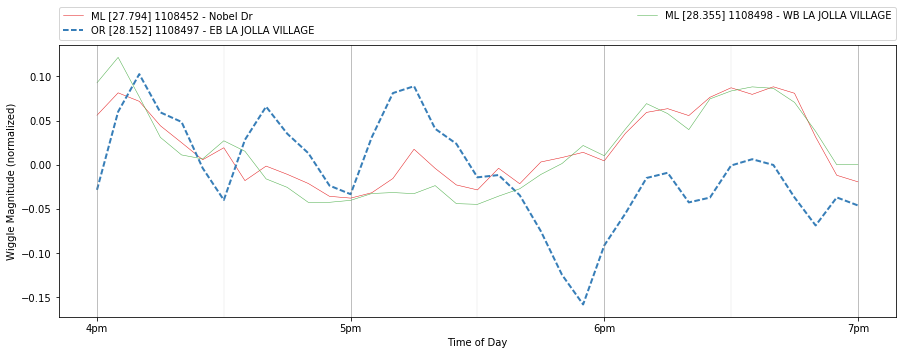

OR [27.794] 1108453 - NOBEL DR https://www.google.com/maps/place/32.864527,-117.230028


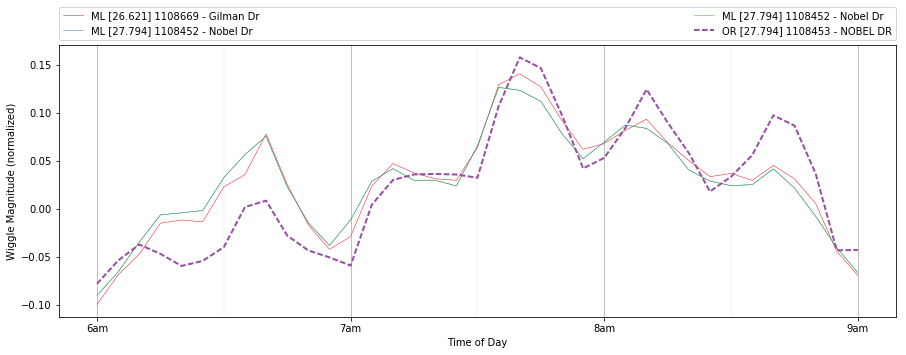

OR [27.794] 1108453 - NOBEL DR https://www.google.com/maps/place/32.864527,-117.230028


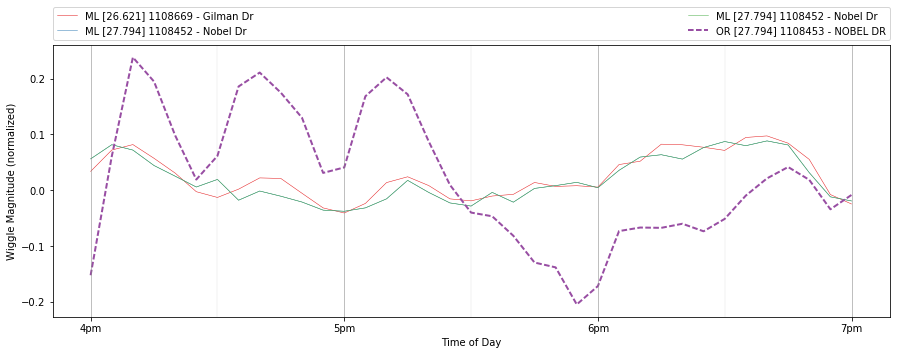

FR [26.621] 1100363 - GILMAN DR to 5SB https://www.google.com/maps/place/32.848532,-117.235725
OR [26.621] 1108670 - GILMAN DR to 5SB https://www.google.com/maps/place/32.848532,-117.235725


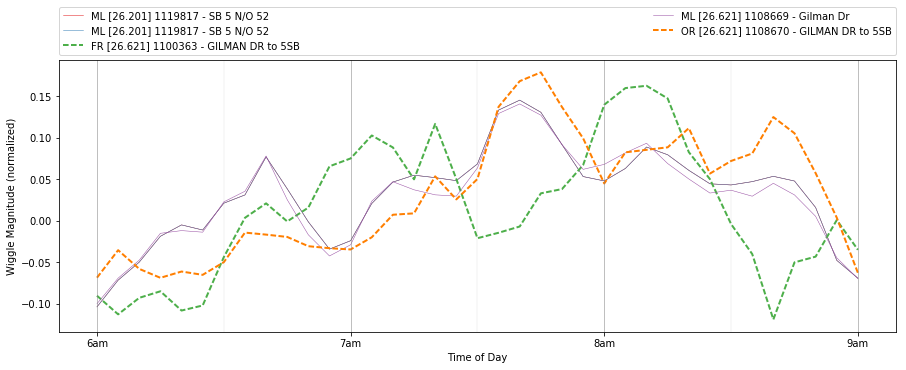

FR [26.621] 1100363 - GILMAN DR to 5SB https://www.google.com/maps/place/32.848532,-117.235725
OR [26.621] 1108670 - GILMAN DR to 5SB https://www.google.com/maps/place/32.848532,-117.235725


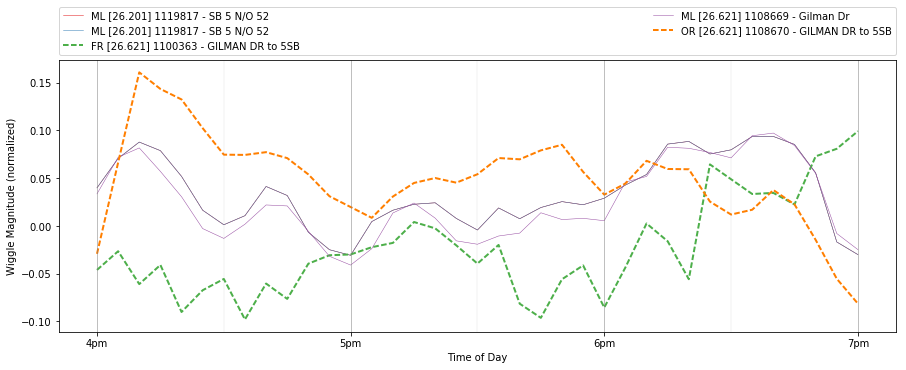

OR [25.739] 1108668 - ARDATH RD/SR-52 https://www.google.com/maps/place/32.836089,-117.234107


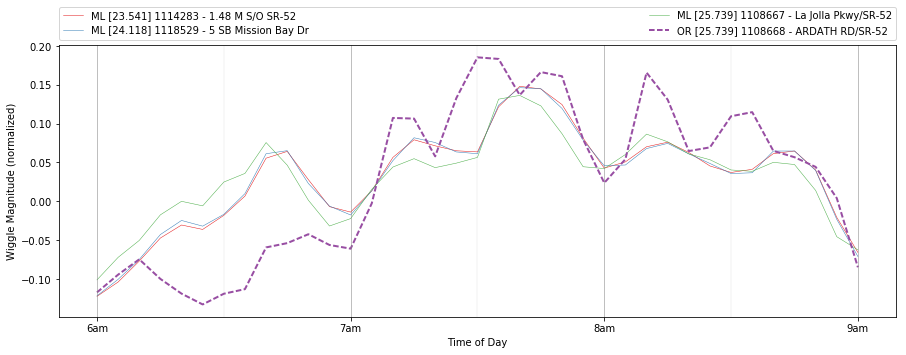

OR [25.739] 1108668 - ARDATH RD/SR-52 https://www.google.com/maps/place/32.836089,-117.234107


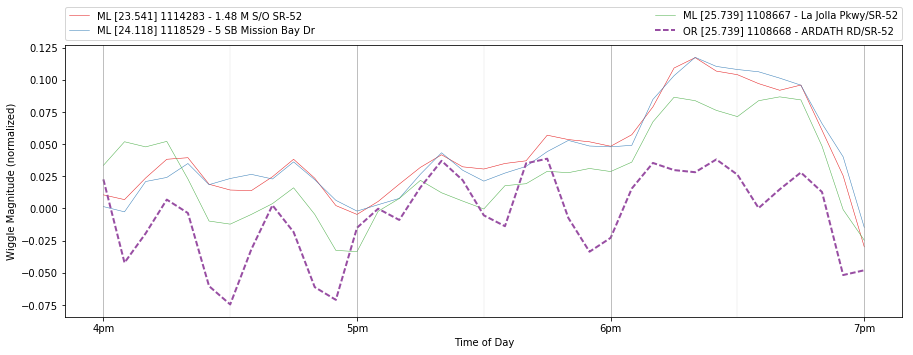

OR [23.466] 1119308 - SB5 @BALBOA AVE https://www.google.com/maps/place/32.807702,-117.216754


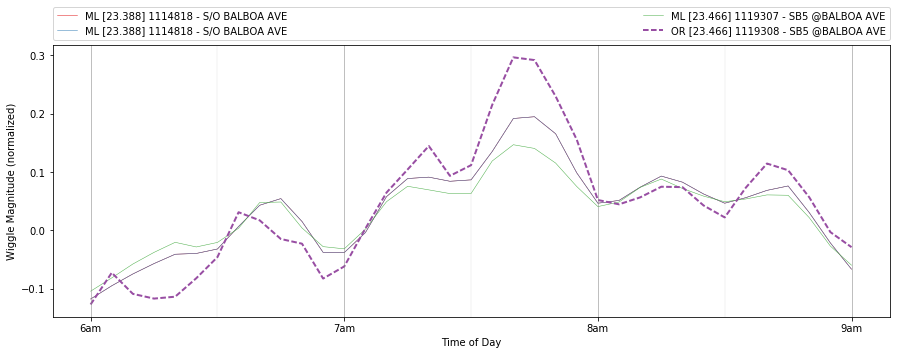

OR [23.466] 1119308 - SB5 @BALBOA AVE https://www.google.com/maps/place/32.807702,-117.216754


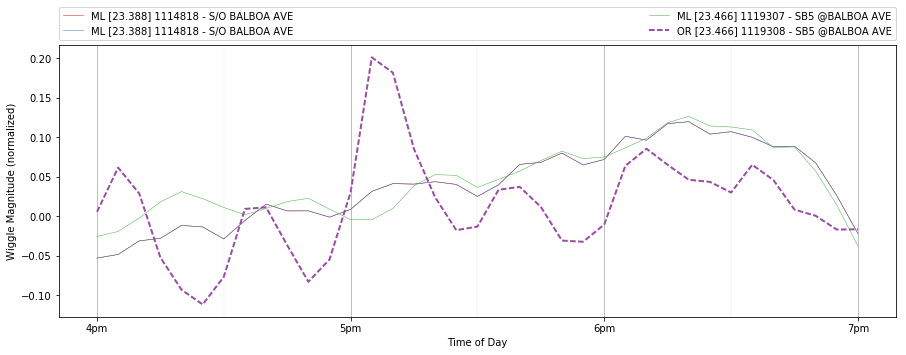

OR [22.85] 1108694 - MISSION BAY DR https://www.google.com/maps/place/32.800051,-117.211487


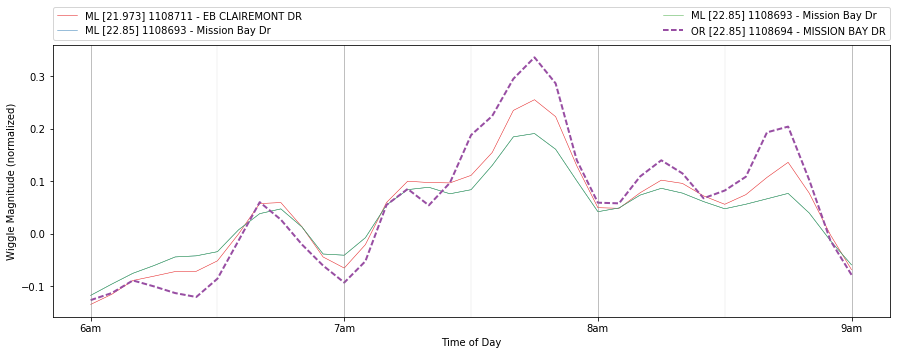

OR [22.85] 1108694 - MISSION BAY DR https://www.google.com/maps/place/32.800051,-117.211487


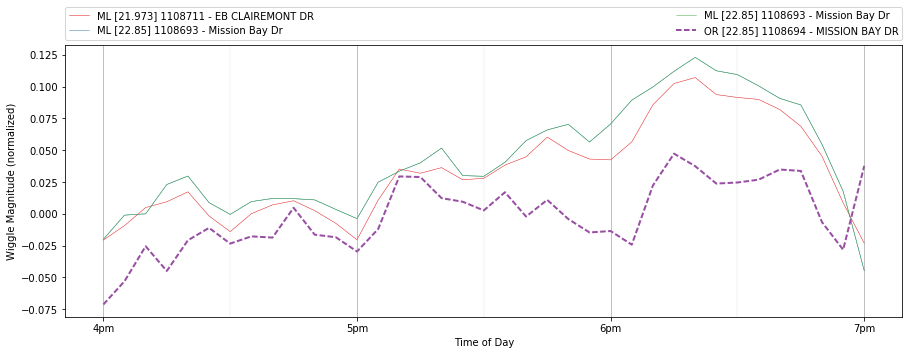

OR [22.212] 1108713 - WB CLAIREMONT DR https://www.google.com/maps/place/32.791448,-117.207392


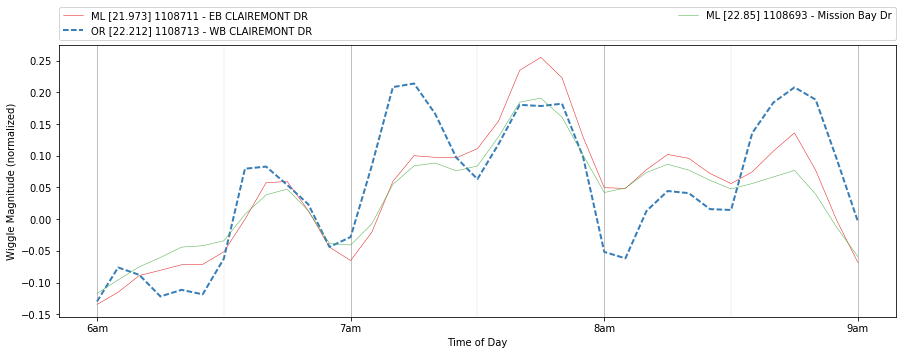

OR [22.212] 1108713 - WB CLAIREMONT DR https://www.google.com/maps/place/32.791448,-117.207392


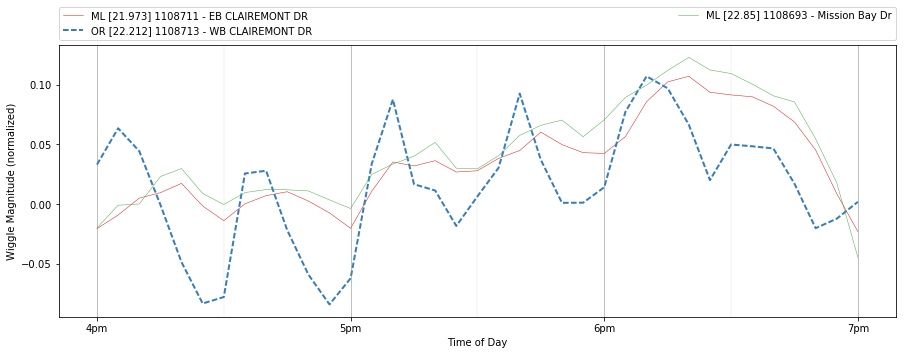

FR [21.973] 1100353 - CLAIREMONT DR https://www.google.com/maps/place/32.788012,-117.207155
OR [21.973] 1108712 - EB CLAIREMONT DR https://www.google.com/maps/place/32.788012,-117.207155


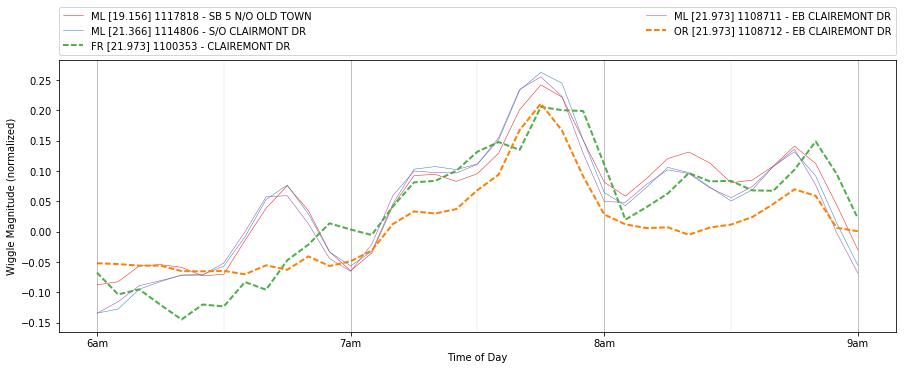

FR [21.973] 1100353 - CLAIREMONT DR https://www.google.com/maps/place/32.788012,-117.207155
OR [21.973] 1108712 - EB CLAIREMONT DR https://www.google.com/maps/place/32.788012,-117.207155


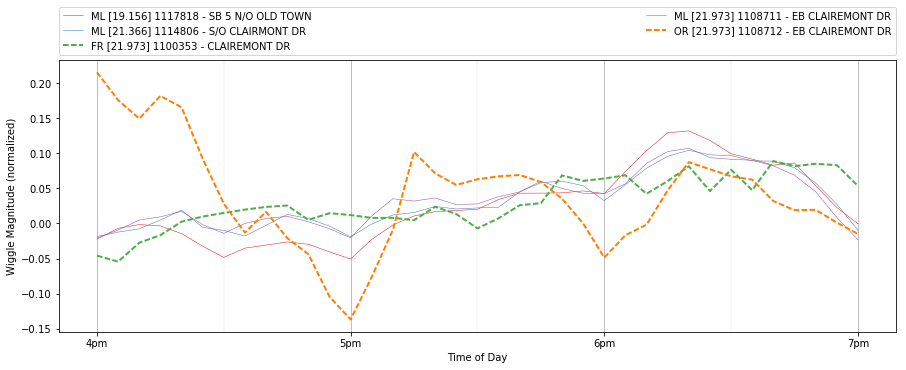

FR [18.822] 1100348 - OLD TOWN/HANCOCK https://www.google.com/maps/place/32.746784,-117.191904
OR [18.822] 1108616 - OLD TOWN AVE https://www.google.com/maps/place/32.746784,-117.191904


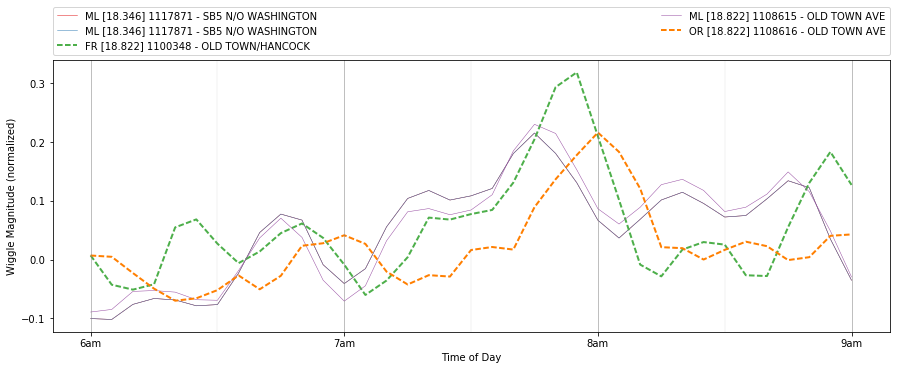

FR [18.822] 1100348 - OLD TOWN/HANCOCK https://www.google.com/maps/place/32.746784,-117.191904
OR [18.822] 1108616 - OLD TOWN AVE https://www.google.com/maps/place/32.746784,-117.191904


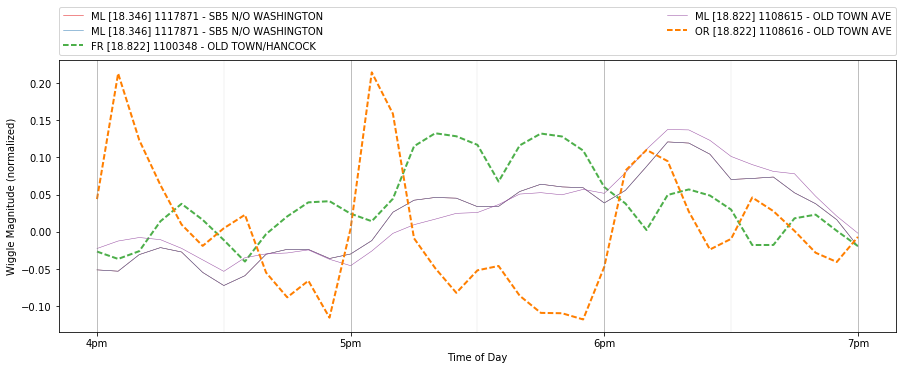

OR [18.05] 1108610 - HANCOCK ST https://www.google.com/maps/place/32.741281,-117.180454


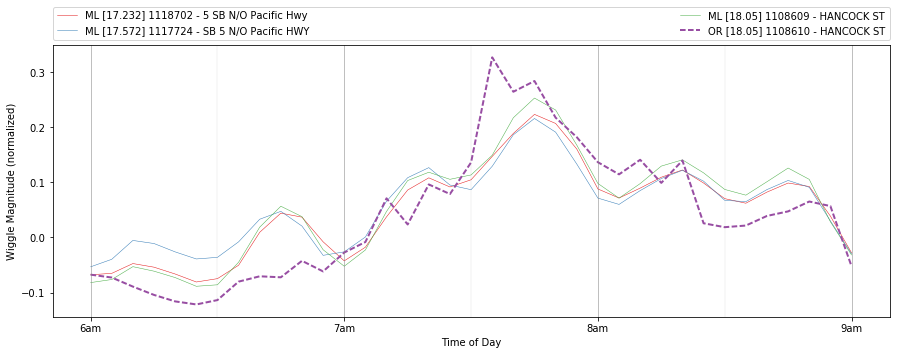

OR [18.05] 1108610 - HANCOCK ST https://www.google.com/maps/place/32.741281,-117.180454


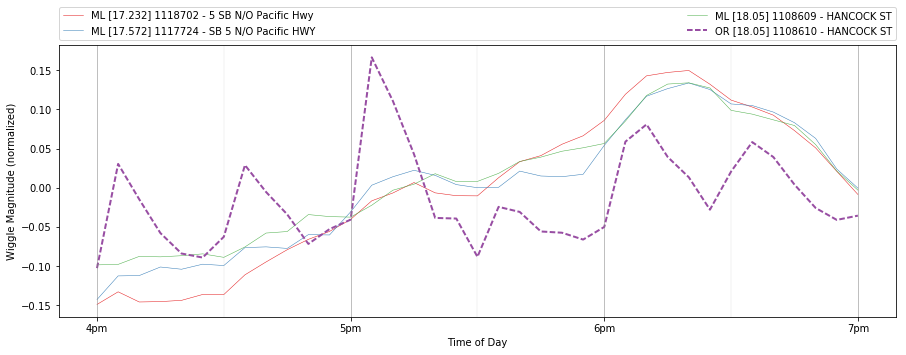

OR [17.23] 1108606 - KETTNER BLVD https://www.google.com/maps/place/32.731834,-117.171905


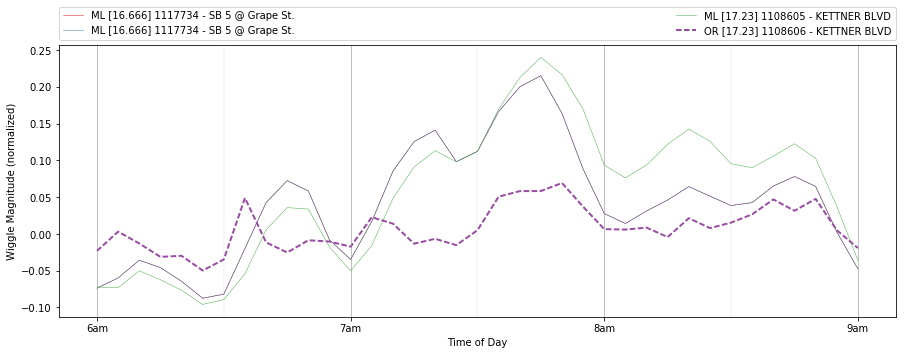

OR [17.23] 1108606 - KETTNER BLVD https://www.google.com/maps/place/32.731834,-117.171905


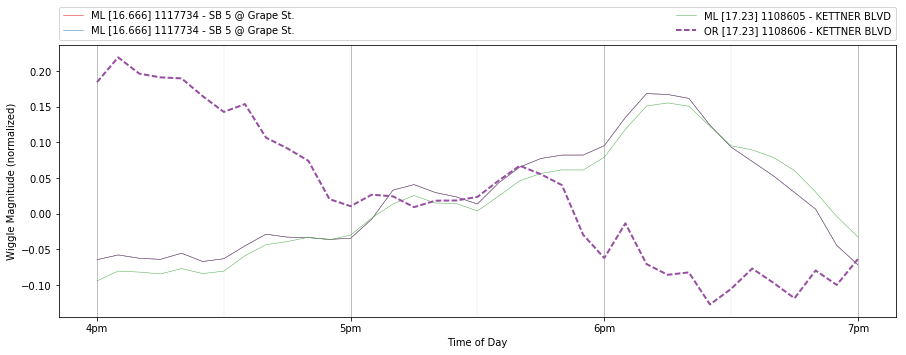

OR [16.001] 1108418 - 5TH AVE https://www.google.com/maps/place/32.723898,-117.156068


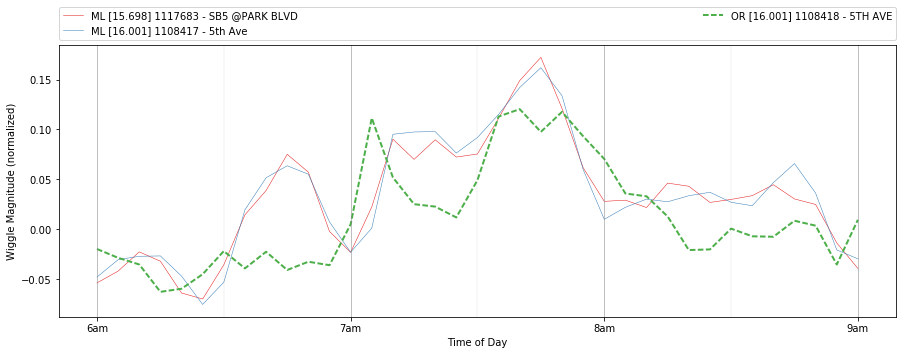

OR [16.001] 1108418 - 5TH AVE https://www.google.com/maps/place/32.723898,-117.156068


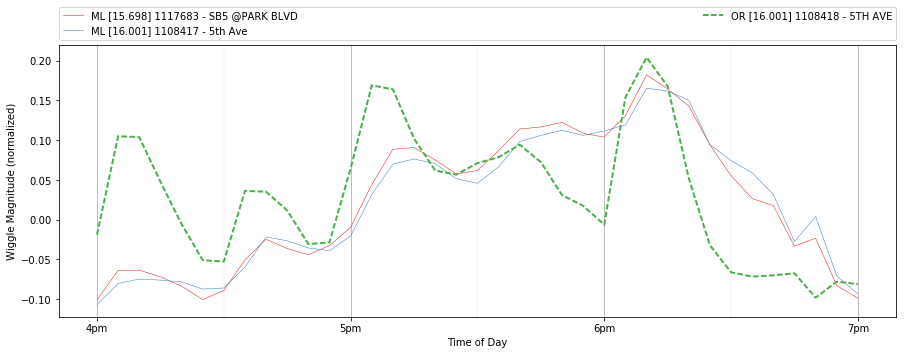

In [94]:
# Time bounds on 24 hour clock
t_min = [6, 16]
t_max = [9, 19]

for stations in station_set:
    for i in range(len(t_min)):
        plot_ramp_wiggles( t_min=t_min[i], t_max=t_max[i], rampid=stations[0] )
